## dataset path

In [1]:
ncku_dataset = 'data/ncku'
vbd_dataset = 'data/vbd'
jsrt_dataset = 'data/jsrt'
# nih_dataset = 'data/nih'
nih_dataset = '/work/jefffang21/nih'

## install package

In [2]:
# !pip install segmentation-models-pytorch

In [3]:
# !pip install -U albumentations

In [4]:
# optimizer
# !pip install madgrad

In [5]:
# warmup
# !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [6]:
# Elastic deformations
# https://github.com/gvtulder/elasticdeform
# !pip install elasticdeform

In [7]:
!nvidia-smi

Tue May 25 10:10:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1C:00.0 Off |                    0 |
| N/A   27C    P0    60W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## imports

In [8]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os
import numpy as np
from cv2 import cv2
from sklearn.model_selection import train_test_split
import albumentations as albu
from torch.utils.data import ConcatDataset

import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

## utils functions

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [10]:
# useful image resize function
# https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

## Get data pathes

In [11]:
# dataset number
# use to keep track of  which image from which dataset
# vbd = 0
#  jsrt = 1
# ncku = 2

In [12]:
class get_vbd_path():
    def __init__(self, path):
        f = open(os.path.join(path, 'dataset/train_x.txt'))
        X_train = f.readlines()
        X_train = ['{}/images/{}'.format(path, i[:-1]) for i in X_train]
        f.close()
        f = open(os.path.join(path, 'dataset/train_y.txt'))
        y_train = f.readlines()
        y_train = ['{}/masks/{}'.format(path, i[:-1]) for i in y_train]
        f.close()
        f = open(os.path.join(path, 'dataset/valid_x.txt'))
        X_valid = f.readlines()
        X_valid = ['{}/images/{}'.format(path, i[:-1]) for i in X_valid]
        f.close()
        f = open(os.path.join(path, 'dataset/valid_y.txt'))
        y_valid = f.readlines()
        y_valid = ['{}/masks/{}'.format(path, i[:-1]) for i in y_valid]
        f.close()
        f = open(os.path.join(path, 'dataset/test_x.txt'))
        X_test = f.readlines()
        X_test = ['{}/images/{}'.format(path, i[:-1]) for i in X_test]
        f.close()
        f = open(os.path.join(path, 'dataset/test_y.txt'))
        y_test = f.readlines()
        y_test = ['{}/masks/{}'.format(path, i[:-1]) for i in y_test]
        f.close()
        self.X_train = X_train + X_valid
        self.y_train = y_train + y_valid
        self.X_test = X_test
        self.y_test = y_test
        self.dataset_num = 0

    def get_train(self):
        return self.X_train, self.y_train

    def get_test(self):
        return self.X_test, self.y_test

    def length(self):
        return len(self.X_train) + len(self.X_test)

In [13]:
class get_jsrt_path():
    def __init__(
            self,
            path,
    ):
        f = open(os.path.join(path, 'dataset/train_x.txt'))
        X_train = f.readlines()
        X_train = ['{}/images/{}'.format(path, i[:-1]) for i in X_train]
        f.close()
        f = open(os.path.join(path, 'dataset/train_y.txt'))
        y_train = f.readlines()
        y_train = ['{}/masks/{}'.format(path, i[:-1]) for i in y_train]
        f.close()
        f = open(os.path.join(path, 'dataset/valid_x.txt'))
        X_valid = f.readlines()
        X_valid = ['{}/images/{}'.format(path, i[:-1]) for i in X_valid]
        f.close()
        f = open(os.path.join(path, 'dataset/valid_y.txt'))
        y_valid = f.readlines()
        y_valid = ['{}/masks/{}'.format(path, i[:-1]) for i in y_valid]
        f.close()
        f = open(os.path.join(path, 'dataset/test_x.txt'))
        X_test = f.readlines()
        X_test = ['{}/images/{}'.format(path, i[:-1]) for i in X_test]
        f.close()
        f = open(os.path.join(path, 'dataset/test_y.txt'))
        y_test = f.readlines()
        y_test = ['{}/masks/{}'.format(path, i[:-1]) for i in y_test]
        f.close()
        self.X_train = X_train + X_valid
        self.y_train = y_train + y_valid
        self.X_test = X_test
        self.y_test = y_test
        self.dataset_num = 1

    def get_train(self):
        return self.X_train, self.y_train
  
    def get_test(self):
        return self.X_test, self.y_test

    def length(self):
        return len(self.X_train) + len(self.X_test)

In [14]:
class get_ncku_path():
    def __init__(
            self,
            path,
    ):
        f = open(os.path.join(path, 'dataset/train_x.txt'))
        X_train = f.readlines()
        X_train = ['{}/{}'.format(path, i[:-1]) for i in X_train]
        f.close()
        f = open(os.path.join(path, 'dataset/train_y.txt'))
        y_train = f.readlines()
        y_train = ['{}/{}'.format(path, i[:-1]) for i in y_train]
        f.close()
        f = open(os.path.join(path, 'dataset/test_x.txt'))
        X_test = f.readlines()
        X_test = ['{}/{}'.format(path, i[:-1]) for i in X_test]
        f.close()
        f = open(os.path.join(path, 'dataset/test_y.txt'))
        y_test = f.readlines()
        y_test = ['{}/{}'.format(path, i[:-1]) for i in y_test]
        f.close()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.dataset_num = 2

    def get_train(self):
        return self.X_train, self.y_train
  
    def get_test(self):
        return self.X_test, self.y_test

    def length(self):
        return len(self.X_train) + len(self.X_test)

In [15]:
import glob

class get_nih_path():
    def __init__(
            self,
            path,
    ):
        # nodule
        f = open(os.path.join(path, 'dataset/train_x1.txt'))
        X_train1 = f.readlines()
        X_train1 = ['{}/{}'.format(path, i[:-1]) for i in X_train1]
        f.close()
        f = open(os.path.join(path, 'dataset/valid_x1.txt'))
        X_valid1 = f.readlines()
        X_valid1 = ['{}/{}'.format(path, i[:-1]) for i in X_valid1]
        f.close()
        f = open(os.path.join(path, 'dataset/test_x1.txt'))
        X_test1 = f.readlines()
        X_test1 = ['{}/{}'.format(path, i[:-1]) for i in X_test1]
        f.close()
        
        # no finding
        self.X2 = glob.glob('{}/*'.format(os.path.join(path, 'no_finding/images')))
        
        self.X_train1 = X_train1
        self.X_valid1 = X_valid1
        self.X_test1 = X_test1

    def get_train(self):
        return self.X_train1 + self.X_valid1 +  self.X_test1, self.X2

    def length(self):
        return ( len(self.X_train1) + len(self.X_valid1) +  len(self.X_test1) ) * 2

## pytorch dataset

In [16]:
class Dataset(BaseDataset):
    """
    Args:
        X, y (list of str): paths of images / labels
        clahe (bool): do clahe or not
        do_resize (tuple of ints): resize the image and mask, if None, DO NOT do resize
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self,
            X,
            y,
            dataset_num,
            clahe = False,
            do_resize = (512, 512),
            augmentation=None, 
            preprocessing=None,
    ):
        self.images = X
        self.masks = y

        # sanity check, check if number of x any y is the same
        if len(self.images) != len(self.masks):
            print('Warning! number of images do not match number of masks')

        # check if do augmentation and preprocess
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.do_resize = do_resize
        self.clahe = clahe
        self.dataset_num = dataset_num
    
    def __getitem__(self, i):

        # read img
        image = cv2.imread(self.images[i], 0) # read  GRAY
        mask = cv2.imread(self.masks[i], 0) # read GRAY
        
        # if jsrt reverse black white
        if self.dataset_num[i] == 1:
            image = 255 - image

        if self.clahe:
            # create a CLAHE object (Arguments are optional).
            clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
            image = clahe.apply(image)

        if self.do_resize:
            # resize
            if image.shape[0] >= image.shape[1]:
                image=image_resize(image, height = self.do_resize[0])
                mask=image_resize(mask, height = self.do_resize[0])
            else:
                image=image_resize(image, width = self.do_resize[1])
                mask=image_resize(mask, width = self.do_resize[1])

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # get origin image before normalization
        ori = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # image channel
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # normalize needs to be done or dice loss will be wrong
        # normalize needs to do after augmentations, or will cause error
        # image = image/255 # normalize image
        mask = mask/255

        # if mask has color
        mask[mask > 0] = 1
            
        return image, mask, ori
        
    def __len__(self):
        return len(self.images)


In [17]:
class DatasetUnlabel(BaseDataset):
    """
    Args:
        X, y (list of str): paths of images / labels
        clahe (bool): do clahe or not
        do_resize (tuple of ints): resize the image and mask, if None, DO NOT do resize
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self,
            X,
            clahe = False,
            do_resize = (512, 512),
            augmentation=None, 
            preprocessing=None,
    ):
        self.images = X
        self.y = np.zeros(len(X))

        # sanity check, check if number of x any y is the same
        if len(self.images) != len(self.y):
            print('Warning! number of images do not match number of y')

        # check if do augmentation and preprocess
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.do_resize = do_resize
        self.clahe = clahe
    
    def __getitem__(self, i):

        # read img
        image = cv2.imread(self.images[i], 0) # read  GRAY
        y = self.y[i]
        
        try:
            ori = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        except:
            image = cv2.imread(self.images[0], 0) # read  GRAY
            y = self.y[0]

        if self.clahe:
            # create a CLAHE object (Arguments are optional).
            clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
            image = clahe.apply(image)

        if self.do_resize:
            # resize
            if image.shape[0] >= image.shape[1]:
                image=image_resize(image, height = self.do_resize[0])
            else:
                image=image_resize(image, width = self.do_resize[1])
                
                
        # get origin image before normalization
        ori = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        x = None
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=np.expand_dims(image, axis=-1))
            x = sample['image']
            
        # normalize 
        x = x/255
            
        return x, y, ori
        
    def __len__(self):
        return len(self.images)


## augmentations and smp preprocess

In [18]:
import albumentations as albu

def get_training_weak_augmentation():
    # Setting Sync with Jun: DONE
    train_transform = [
            albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=4),
            # albu.CLAHE(always_apply=True),
            albu.RandomCrop(height=200, width=200, p=0.2),
            albu.HorizontalFlip(p=0.5),
            albu.ShiftScaleRotate(scale_limit=0.25, rotate_limit=0.25,shift_limit=0.1, p=1, border_mode=4),
            albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=4),
    ]

    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(256, 256, always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=0)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_preprocessing_no_pretrain():
    """Construct preprocessing transform
    
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

## get  dataset

In [19]:
# lazy person function
# a function return train, test datasets
def get_datasets(ncku_path, jsrt_path, vbd_path):

    # set data path
    vbd = get_vbd_path(vbd_path)
    jsrt = get_jsrt_path(jsrt_path)
    ncku = get_ncku_path(ncku_path)
    
    # get data from each set
    vbd_train_x, vbd_train_y = vbd.get_train()
    vbd_test_x, vbd_test_y = vbd.get_test()
    
    jsrt_train_x, jsrt_train_y = jsrt.get_train()
    jsrt_test_x, jsrt_test_y = jsrt.get_test()
    
    ncku_train_x, ncku_train_y = ncku.get_train()
    ncku_test_x, ncku_test_y = ncku.get_test()

    # merge
    X_train = vbd_train_x + jsrt_train_x + ncku_train_x
    y_train = vbd_train_y + jsrt_train_y + ncku_train_y
    X_test = vbd_test_x + jsrt_test_x + ncku_test_x
    y_test = vbd_test_y + jsrt_test_y + ncku_test_y
    
    dataset_num_train = np.concatenate([np.zeros_like(vbd_train_x, dtype='int'), np.ones_like(jsrt_train_x,  dtype='int'), np.ones_like(ncku_train_x,  dtype='int')*2 ])
    dataset_num_test = np.concatenate([np.zeros_like(vbd_test_x,  dtype='int'), np.ones_like(jsrt_test_x,  dtype='int'), np.ones_like(ncku_test_x,  dtype='int')*2 ])
    
    # create dataset
    trainset = Dataset(X_train, y_train, dataset_num_train, augmentation=get_training_weak_augmentation(), preprocessing=get_preprocessing(preprocessing_fn), clahe=False)
    testset = Dataset(X_test, y_test, dataset_num_test, augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn), clahe=False)

    return trainset, testset

In [20]:
def get_datasets_nih(nih_path):
    nih = get_nih_path(nih_path)
    
    x1, x2 = nih.get_train()
    
    print(len(x1), len(x2))
    
    trainset = DatasetUnlabel(x2[:40000], augmentation=get_training_weak_augmentation(), preprocessing=get_preprocessing_no_pretrain(), clahe=False, do_resize=(256, 256))
    testset = DatasetUnlabel(x2[40000:], augmentation=get_validation_augmentation(), preprocessing=get_preprocessing_no_pretrain(), clahe=False, do_resize=(256, 256))
    abset = DatasetUnlabel(x1, augmentation=get_validation_augmentation(), preprocessing=get_preprocessing_no_pretrain(), clahe=False, do_resize=(256, 256))
    
    return trainset, testset, abset

## Define VAE

https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [21]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [22]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [23]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(256, h_dim, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 256, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=4, stride=2),
            nn.AdaptiveAvgPool2d((256, 256)),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(DEVICE)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

# if __main__

In [24]:
save_model_path = 'weights'

### define model

In [25]:
DEVICE = 'cuda:0'

model = VAE(image_channels=1).to(DEVICE)

In [26]:
# model.load_state_dict(torch.load('ae.pth', map_location=DEVICE))

In [27]:
# https://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html
# MULTI-GPU
# model = nn.DataParallel(model)

### get dataset instances

In [28]:
# unsupervised set
trainset, validset, abset = get_datasets_nih(nih_dataset)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=4)
validset_loader = torch.utils.data.DataLoader(validset, batch_size=1024, shuffle=False, num_workers=4)
abset_loader = torch.utils.data.DataLoader(abset, batch_size=1024, shuffle=False, num_workers=4)

6331 59524


In [29]:
print(len(trainset), len(validset))

40000 19524


(1, 256, 256) (256, 256, 3)
0.0
0.96862745 0.0


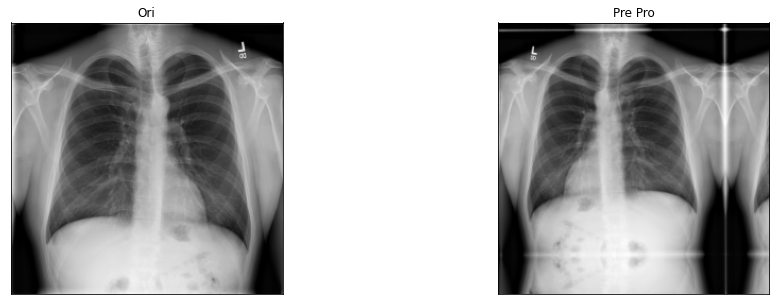

In [30]:
# visualization
image, _y, ori = trainset[500]

print(image.shape, ori.shape)
print(_y)

print(np.max(image), np.min(image))


# visual data
visualize(
    ori=ori,
    pre_pro=image[0],
)

torch.Size([1, 1, 256, 256])


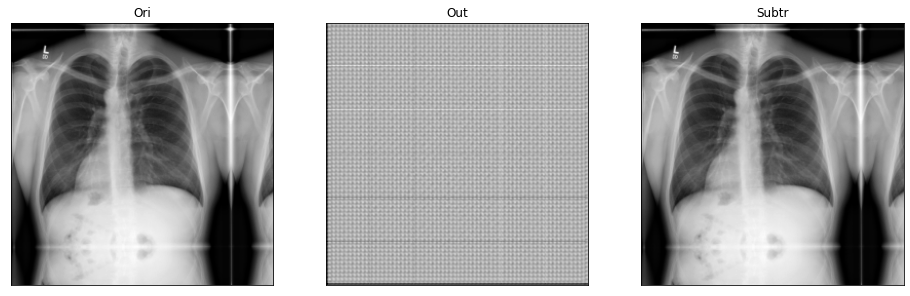

In [31]:
x_in = torch.tensor(image).unsqueeze(0).cuda()

with torch.no_grad():
    out = model(x_in)

x_out = out[0].cpu()

print(x_out.shape)
# visual data
visualize(
    ori=image.squeeze(),
    out=x_out.numpy().squeeze(),
    
    subtr = image.squeeze() - x_out.numpy().squeeze(),
)

(1, 256, 256) (256, 256, 3)
0.0


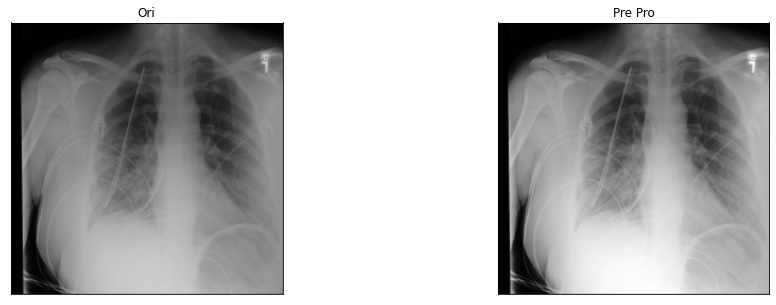

In [32]:
# visualization
image, _y, ori = validset[500]

print(image.shape, ori.shape)
print(_y)


# visual data
visualize(
    ori=ori,
    pre_pro=image[0],
)

torch.Size([1, 1, 256, 256])


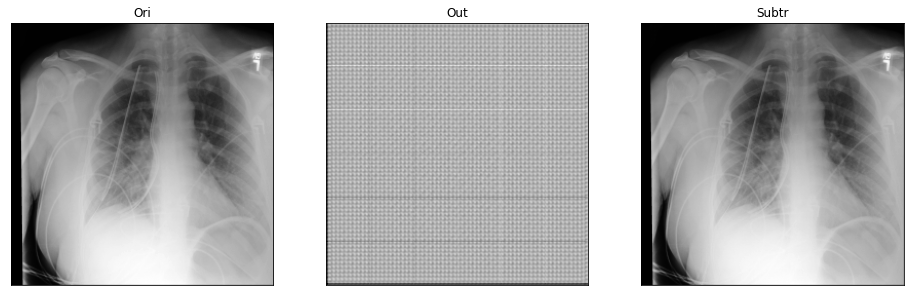

In [33]:
x_in = torch.tensor(image).unsqueeze(0).cuda()

with torch.no_grad():
    out = model(x_in)

x_out = out[0].cpu()

print(x_out.shape)
# visual data
visualize(
    ori=image.squeeze(),
    out=x_out.numpy().squeeze(),
    
    subtr = image.squeeze() - x_out.numpy().squeeze(),
)

(1, 256, 256) (256, 256, 3)
0.0


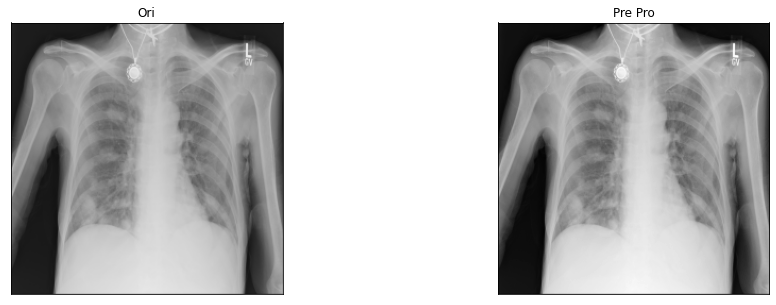

In [34]:
# visualization
image, _y, ori = abset[500]

print(image.shape, ori.shape)
print(_y)


# visual data
visualize(
    ori=ori,
    pre_pro=image[0],
)

torch.Size([1, 1, 256, 256])


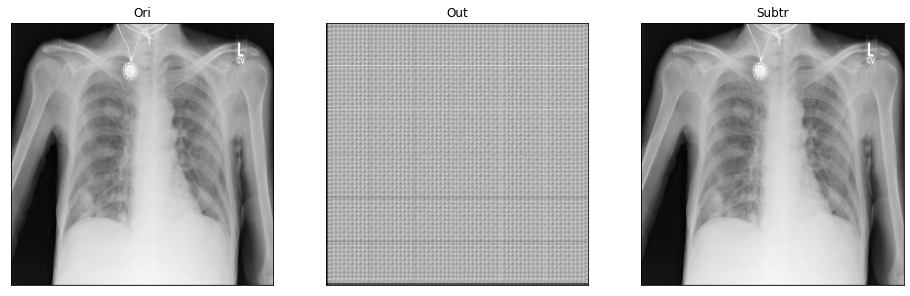

In [35]:
x_in = torch.tensor(image).unsqueeze(0).cuda()

with torch.no_grad():
    out = model(x_in)

x_out = out[0].cpu()

print(x_out.shape)
# visual data
visualize(
    ori=image.squeeze(),
    out=x_out.numpy().squeeze(),
    
    subtr = image.squeeze() - x_out.numpy().squeeze(),
)

## training setup

### loss functions and metrics

In [36]:
loss = smp.utils.losses.MSELoss()

In [37]:
LR = 4e-4

EPOCH = 300

In [38]:
# choose optimizer

import madgrad

# adam
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# try new optimizer by Facebook
optimizer = madgrad.MADGRAD(model.parameters(), lr=LR)

In [39]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler

In [40]:
# lr schduling :  warmup

# scheduler_warmup is chained with schduler_steplr
scheduler_steplr = CosineAnnealingLR(optimizer, EPOCH)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=2, after_scheduler=scheduler_steplr)

/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.

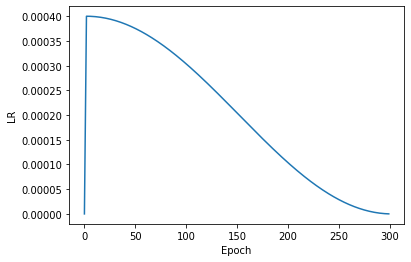

In [41]:
# plot learning rate
epoches = []
lrs = []
for epoch in range(EPOCH):
    scheduler_warmup.step(epoch)
    epoches.append(epoch)
    lrs.append(optimizer.param_groups[0]['lr'])
    
plt.plot(lrs)
plt.ylabel('LR')
plt.xlabel('Epoch')

scheduler_steplr = CosineAnnealingLR(optimizer, EPOCH)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=20, after_scheduler=scheduler_steplr)

## training script

In [42]:
torch.cuda.empty_cache()

In [43]:
!nvidia-smi

Tue May 25 10:10:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1C:00.0 Off |                    0 |
| N/A   26C    P0    55W / 300W |   1352MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
from tqdm import tqdm

In [45]:
def training_step(epoch):
    '''
    return each batch of training loss
    type: np array
    '''
    
    model.cuda()            

    # step lr scheduler
    scheduler_warmup.step(epoch)
    print('epoch: {}, lr: {}'.format(epoch, optimizer.param_groups[0]['lr']))
    
    train_loss = []
    torch.cuda.empty_cache()
    for x, _, _ in tqdm(trainset_loader): 
        if torch.cuda.is_available():
            x = x.cuda()
        
        optimizer.zero_grad()     #optimizer gradient to zero
        ## 1. forward propagationreal_labels
        ## -----------------------
        x_recon = model(x)
        ## 2. loss calculation
        ## -----------------------
        
        _loss = loss(x_recon[0], x)
        ## 3. backward propagation
        ## -----------------------
        _loss.backward()     
        ## 4. weight optimization
        ## -----------------------        
        optimizer.step()
        train_loss.append(_loss.item())
        
    return np.array(train_loss)

In [46]:
def eval_step():
    '''
    return each batch of eval metrics, tp, fp, fn
    type: np array
    '''
    model.cuda()
    
    torch.cuda.empty_cache()
    valid = []
    valid_ab = []
    # use no_grad when evaluating
    with torch.no_grad():
        for x, _, _ in tqdm(validset_loader):
            if torch.cuda.is_available():
                x = x.cuda()

            # fit model
            pred = model(x)
            
            valid.append(loss(pred[0], x).item())
            
        for x, _, _ in tqdm(abset_loader):
            if torch.cuda.is_available():
                x = x.cuda()

            # fit model
            pred = model(x)
            
            valid_ab.append(loss(pred[0], x).item())

            
    return np.array(valid), np.array(valid_ab)


In [47]:
def plot_result(path, tr_loss, val_loss, ab_loss):
    '''
    plot result to path
    results:
    trloss.png
    valloss.png
    '''
    
    # plot training loss
    fig , ax = plt.subplots()
    plt.plot(tr_loss, label='train')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    leg = ax.legend(loc='upper left', shadow=True) 
    # plt.figure(figsize = (12,12))
    plt.savefig(os.path.join(path, 'trloss.png'))
    plt.clf()
    plt.close(fig)
    
    # plot valid
    fig , ax = plt.subplots()
    plt.plot(val_loss, label='valid')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    leg = ax.legend(loc='upper left', shadow=True) 
    # plt.figure(figsize = (12,12))
    plt.savefig(os.path.join(path, 'valloss.png'))
    plt.clf()
    
    plt.close(fig)
    
    # plot valid
    fig , ax = plt.subplots()
    plt.plot(ab_loss, label='abnormal')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    leg = ax.legend(loc='upper left', shadow=True) 
    # plt.figure(figsize = (12,12))
    plt.savefig(os.path.join(path, 'abnormalloss.png'))
    plt.clf()
    
    plt.close(fig)

## Do training

In [48]:
training_reports = {
    'val_loss' : [],
    'tr_loss' : [],
    'ab_loss' : [],
    'min_val_mse' : 99999999
}

In [49]:
# train model for N epochs
# for epoch in range(1, EPOCH+1):
for epoch in range(1, EPOCH+1):
    # Train 
    
    train_loss = training_step(epoch)
    
    # evaluate
    valid_loss, ab_loss  = eval_step()
    
    # print training status of this epoch
    print("Epoch:", epoch, "Training Loss: {}, Valid Loss: {}, abnormal Loss:{}".format(np.mean(train_loss), np.mean(valid_loss), np.mean(ab_loss)) )
    # track result
    training_reports['tr_loss'].append(np.mean(train_loss))
    training_reports['val_loss'].append(np.mean(valid_loss))
    training_reports['ab_loss'].append(np.mean(ab_loss))
    
    # calculate current best result
    print('min valid mse {}'.format(np.min(training_reports['val_loss'])))

    # plot
    plot_result(save_model_path, training_reports['tr_loss'], training_reports['val_loss'], training_reports['ab_loss'])

    # save model 
    if np.mean(valid_loss) < training_reports['min_val_mse']:
        training_reports['min_val_mse'] = np.mean(valid_loss)
        torch.save(model.state_dict(), os.path.join(save_model_path, 'best_model.pth'))
        print('Model saved!')
        
    # save every 30 epoches
    if epoch % 30 == 0:
        torch.save(model.state_dict(), os.path.join(save_model_path, 'model_{}.pth'.format(epoch)))

    # save last model
    torch.save(model.state_dict(), os.path.join(save_model_path, 'last_model.pth'))

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 1, lr: 2e-05


100%|██████████| 7/7 [01:02<00:00,  8.96s/it]


Epoch: 1 Training Loss: 0.061299622524529696, Valid Loss: 0.06487838290631771, abnormal Loss:0.0647320704800742
min valid mse 0.06487838290631771


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 2, lr: 4e-05


100%|██████████| 7/7 [01:01<00:00,  8.72s/it]


Epoch: 2 Training Loss: 0.060932903178036214, Valid Loss: 0.06445603743195534, abnormal Loss:0.0643400592463357
min valid mse 0.06445603743195534


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 3, lr: 6e-05


100%|██████████| 7/7 [00:59<00:00,  8.44s/it]


Epoch: 3 Training Loss: 0.0604559519328177, Valid Loss: 0.0639179315418005, abnormal Loss:0.06384390486138207
min valid mse 0.0639179315418005


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 4, lr: 8e-05


100%|██████████| 7/7 [00:59<00:00,  8.56s/it]


Epoch: 4 Training Loss: 0.059836698696017265, Valid Loss: 0.06325070671737194, abnormal Loss:0.06322799782667841
min valid mse 0.06325070671737194


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 5, lr: 0.0001


100%|██████████| 7/7 [01:00<00:00,  8.70s/it]


Epoch: 5 Training Loss: 0.05885752839967608, Valid Loss: 0.06145375184714794, abnormal Loss:0.061448030705962865
min valid mse 0.06145375184714794


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 6, lr: 0.00012


100%|██████████| 7/7 [01:03<00:00,  9.05s/it]


Epoch: 6 Training Loss: 0.05166469141840935, Valid Loss: 0.04679691884666681, abnormal Loss:0.04624301195144653
min valid mse 0.04679691884666681


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 7, lr: 0.00014


100%|██████████| 7/7 [01:02<00:00,  8.95s/it]


Epoch: 7 Training Loss: 0.044768158067017796, Valid Loss: 0.04439943358302116, abnormal Loss:0.04367577337792942
min valid mse 0.04439943358302116


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 8, lr: 0.00016


100%|██████████| 7/7 [01:00<00:00,  8.69s/it]


Epoch: 8 Training Loss: 0.04313244828954339, Valid Loss: 0.04261177219450474, abnormal Loss:0.04185435441987855
min valid mse 0.04261177219450474


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 9, lr: 0.00018


100%|██████████| 7/7 [01:03<00:00,  9.10s/it]


Epoch: 9 Training Loss: 0.0411596211604774, Valid Loss: 0.04032472055405378, abnormal Loss:0.03964805709464209
min valid mse 0.04032472055405378


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 10, lr: 0.0002


100%|██████████| 7/7 [00:59<00:00,  8.50s/it]


Epoch: 10 Training Loss: 0.040074792224913836, Valid Loss: 0.038752943463623526, abnormal Loss:0.03818705039364951
min valid mse 0.038752943463623526


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 11, lr: 0.00022000000000000003


100%|██████████| 7/7 [01:00<00:00,  8.70s/it]


Epoch: 11 Training Loss: 0.039039879385381934, Valid Loss: 0.03751461673527956, abnormal Loss:0.03703344613313675
min valid mse 0.03751461673527956


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 12, lr: 0.00024


100%|██████████| 7/7 [01:01<00:00,  8.71s/it]


Epoch: 12 Training Loss: 0.03792822873219848, Valid Loss: 0.03614193312823773, abnormal Loss:0.03559604553239686
min valid mse 0.03614193312823773


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 13, lr: 0.00026000000000000003


100%|██████████| 7/7 [00:58<00:00,  8.40s/it]


Epoch: 13 Training Loss: 0.03650419134646654, Valid Loss: 0.034786367788910866, abnormal Loss:0.034218688628503253
min valid mse 0.034786367788910866


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 14, lr: 0.00028


100%|██████████| 7/7 [01:02<00:00,  8.94s/it]


Epoch: 14 Training Loss: 0.0356052266433835, Valid Loss: 0.033380141295492646, abnormal Loss:0.03292029670306614
min valid mse 0.033380141295492646


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 15, lr: 0.00030000000000000003


100%|██████████| 7/7 [01:02<00:00,  8.97s/it]


Epoch: 15 Training Loss: 0.03506009355187416, Valid Loss: 0.032280423864722255, abnormal Loss:0.03179750671344144
min valid mse 0.032280423864722255


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 16, lr: 0.00032


100%|██████████| 7/7 [01:03<00:00,  9.01s/it]


Epoch: 16 Training Loss: 0.03298013713210821, Valid Loss: 0.030497891269624232, abnormal Loss:0.030126302370003293
min valid mse 0.030497891269624232


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 17, lr: 0.00034


100%|██████████| 7/7 [01:03<00:00,  9.02s/it]


Epoch: 17 Training Loss: 0.03320761709474027, Valid Loss: 0.03105210727080703, abnormal Loss:0.030436254239508083
min valid mse 0.030497891269624232


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 18, lr: 0.00036


100%|██████████| 7/7 [01:02<00:00,  8.99s/it]


Epoch: 18 Training Loss: 0.0313990717753768, Valid Loss: 0.028410489670932293, abnormal Loss:0.02818206644483975
min valid mse 0.028410489670932293


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 19, lr: 0.00038


100%|██████████| 7/7 [01:03<00:00,  9.04s/it]


Epoch: 19 Training Loss: 0.02931009833700955, Valid Loss: 0.02628596732392907, abnormal Loss:0.025932201317378452
min valid mse 0.02628596732392907


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 20, lr: 0.0004


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 20 Training Loss: 0.02825526688247919, Valid Loss: 0.02615592973306775, abnormal Loss:0.025826019634093558
min valid mse 0.02615592973306775


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 21, lr: 0.0004


100%|██████████| 7/7 [01:01<00:00,  8.74s/it]


Epoch: 21 Training Loss: 0.026256776135414838, Valid Loss: 0.02260803757235408, abnormal Loss:0.022409316152334213
min valid mse 0.02260803757235408


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 22, lr: 0.0003999561366949691


100%|██████████| 7/7 [00:49<00:00,  7.13s/it]


Epoch: 22 Training Loss: 0.024213628796860575, Valid Loss: 0.021897710766643284, abnormal Loss:0.021531217066305026
min valid mse 0.021897710766643284


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 23, lr: 0.00039990131207314633


100%|██████████| 7/7 [00:42<00:00,  6.11s/it]


Epoch: 23 Training Loss: 0.023316867602989077, Valid Loss: 0.020621833112090825, abnormal Loss:0.020310496113130024
min valid mse 0.020621833112090825


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 24, lr: 0.0003998245660197717


100%|██████████| 7/7 [01:00<00:00,  8.64s/it]


Epoch: 24 Training Loss: 0.022157170297577976, Valid Loss: 0.020138039160519837, abnormal Loss:0.020237732146467482
min valid mse 0.020138039160519837


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 25, lr: 0.0003997259069509148


100%|██████████| 7/7 [01:00<00:00,  8.70s/it]


Epoch: 25 Training Loss: 0.021657174080610277, Valid Loss: 0.020028640702366828, abnormal Loss:0.01979033090174198
min valid mse 0.020028640702366828


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 26, lr: 0.00039960534568565434


100%|██████████| 7/7 [01:02<00:00,  8.87s/it]


Epoch: 26 Training Loss: 0.02067304919473827, Valid Loss: 0.018207224365323783, abnormal Loss:0.018348708216633116
min valid mse 0.018207224365323783


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 27, lr: 0.00039946289544489163


100%|██████████| 7/7 [01:01<00:00,  8.81s/it]


Epoch: 27 Training Loss: 0.01988156675361097, Valid Loss: 0.017341019585728645, abnormal Loss:0.017444190702268055
min valid mse 0.017341019585728645
Model saved!
epoch: 28, lr: 0.0003992985718499009


100%|██████████| 7/7 [00:59<00:00,  8.52s/it]


Epoch: 28 Training Loss: 0.01890014563687146, Valid Loss: 0.017067829612642527, abnormal Loss:0.017240782933575765
min valid mse 0.017067829612642527


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 29, lr: 0.00039911239292061604


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 29 Training Loss: 0.018559006368741394, Valid Loss: 0.01585812885314226, abnormal Loss:0.01608185682977949
min valid mse 0.01585812885314226


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 30, lr: 0.0003989043790736547


100%|██████████| 7/7 [00:37<00:00,  5.40s/it]


Epoch: 30 Training Loss: 0.018021824955940246, Valid Loss: 0.015320505900308489, abnormal Loss:0.015545528781201159
min valid mse 0.015320505900308489
Model saved!


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 31, lr: 0.00039867455312007926


100%|██████████| 7/7 [00:40<00:00,  5.85s/it]


Epoch: 31 Training Loss: 0.017827340215444566, Valid Loss: 0.01711691040545702, abnormal Loss:0.017199210822582245
min valid mse 0.015320505900308489


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 32, lr: 0.0003984229402628956


100%|██████████| 7/7 [00:44<00:00,  6.42s/it]


Epoch: 32 Training Loss: 0.0169469540938735, Valid Loss: 0.014499761769548059, abnormal Loss:0.014787279468561922
min valid mse 0.014499761769548059


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 33, lr: 0.0003981495680942887


100%|██████████| 7/7 [00:46<00:00,  6.70s/it]


Epoch: 33 Training Loss: 0.01654743356630206, Valid Loss: 0.014531537657603621, abnormal Loss:0.014664553238877229
min valid mse 0.014499761769548059


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 34, lr: 0.00039785446659259773


100%|██████████| 7/7 [00:39<00:00,  5.60s/it]


Epoch: 34 Training Loss: 0.016820031334646046, Valid Loss: 0.014536495367065073, abnormal Loss:0.014819758545075144
min valid mse 0.014499761769548059


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 35, lr: 0.00039753766811902755


100%|██████████| 7/7 [00:35<00:00,  5.01s/it]


Epoch: 35 Training Loss: 0.015661767520941793, Valid Loss: 0.013668478606268764, abnormal Loss:0.01394802930631808
min valid mse 0.013668478606268764


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 36, lr: 0.000397199207414101


100%|██████████| 7/7 [00:36<00:00,  5.25s/it]


Epoch: 36 Training Loss: 0.01512278059963137, Valid Loss: 0.015529753593727946, abnormal Loss:0.015759690132524286
min valid mse 0.013668478606268764


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 37, lr: 0.0003968391215938484


100%|██████████| 7/7 [00:43<00:00,  6.26s/it]


Epoch: 37 Training Loss: 0.015000918065197766, Valid Loss: 0.013992137974128127, abnormal Loss:0.014204950471009527
min valid mse 0.013668478606268764


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 38, lr: 0.0003964574501457378


100%|██████████| 7/7 [00:44<00:00,  6.38s/it]


Epoch: 38 Training Loss: 0.014395998232066632, Valid Loss: 0.014045152300968766, abnormal Loss:0.014232108635561807
min valid mse 0.013668478606268764


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 39, lr: 0.00039605423492434437


100%|██████████| 7/7 [00:44<00:00,  6.43s/it]


Epoch: 39 Training Loss: 0.013882480678148568, Valid Loss: 0.014345057494938373, abnormal Loss:0.01446022346083607
min valid mse 0.013668478606268764


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 40, lr: 0.00039562952014676116


100%|██████████| 7/7 [00:36<00:00,  5.20s/it]


Epoch: 40 Training Loss: 0.01424511258956045, Valid Loss: 0.012086994340643286, abnormal Loss:0.012233751293803965
min valid mse 0.012086994340643286


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 41, lr: 0.00039518335238774953


100%|██████████| 7/7 [00:35<00:00,  5.07s/it]


Epoch: 41 Training Loss: 0.013110907631926239, Valid Loss: 0.013128173304721713, abnormal Loss:0.013290800553347384
min valid mse 0.012086994340643286


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 42, lr: 0.0003947157805746321


100%|██████████| 7/7 [00:47<00:00,  6.75s/it]


Epoch: 42 Training Loss: 0.013109597773291171, Valid Loss: 0.013605390908196568, abnormal Loss:0.013832282408007554
min valid mse 0.012086994340643286


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 43, lr: 0.00039422685598192723


100%|██████████| 7/7 [00:48<00:00,  6.99s/it]


Epoch: 43 Training Loss: 0.01276587094180286, Valid Loss: 0.014688455080613495, abnormal Loss:0.014917908502476556
min valid mse 0.012086994340643286


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 44, lr: 0.0003937166322257262


100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Epoch: 44 Training Loss: 0.012711609108373522, Valid Loss: 0.011643643770366908, abnormal Loss:0.011808306510959352
min valid mse 0.011643643770366908


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 45, lr: 0.00039318516525781367


100%|██████████| 7/7 [00:43<00:00,  6.25s/it]


Epoch: 45 Training Loss: 0.012475742329843342, Valid Loss: 0.011130351573228836, abnormal Loss:0.011305315153939384
min valid mse 0.011130351573228836


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 46, lr: 0.00039263251335953166


100%|██████████| 7/7 [00:34<00:00,  4.92s/it]


Epoch: 46 Training Loss: 0.01187756834551692, Valid Loss: 0.010804723156616092, abnormal Loss:0.010930579554821764
min valid mse 0.010804723156616092


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 47, lr: 0.0003920587371353886


100%|██████████| 7/7 [00:28<00:00,  4.13s/it]


Epoch: 47 Training Loss: 0.011851105326786637, Valid Loss: 0.010667281830683351, abnormal Loss:0.010801411366888456
min valid mse 0.010667281830683351


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 48, lr: 0.00039146389950641346


100%|██████████| 7/7 [00:29<00:00,  4.21s/it]


Epoch: 48 Training Loss: 0.011647497210651636, Valid Loss: 0.010315465694293379, abnormal Loss:0.010477714506643159
min valid mse 0.010315465694293379


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 49, lr: 0.0003908480657032554


100%|██████████| 7/7 [00:46<00:00,  6.69s/it]


Epoch: 49 Training Loss: 0.011561024468392134, Valid Loss: 0.012242365209385753, abnormal Loss:0.012466623846973692
min valid mse 0.010315465694293379


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 50, lr: 0.00039021130325903074


100%|██████████| 7/7 [00:32<00:00,  4.63s/it]


Epoch: 50 Training Loss: 0.011402060859836638, Valid Loss: 0.010813713166862726, abnormal Loss:0.011015380466622966
min valid mse 0.010315465694293379


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 51, lr: 0.0003895536820019172


100%|██████████| 7/7 [00:33<00:00,  4.75s/it]


Epoch: 51 Training Loss: 0.011091276234947146, Valid Loss: 0.01098856097087264, abnormal Loss:0.011132374405860901
min valid mse 0.010315465694293379


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 52, lr: 0.00038887527404749624


100%|██████████| 7/7 [00:32<00:00,  4.69s/it]


Epoch: 52 Training Loss: 0.011291415733285248, Valid Loss: 0.010176095273345709, abnormal Loss:0.010396115481853485
min valid mse 0.010176095273345709


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 53, lr: 0.00038817615379084514


100%|██████████| 7/7 [00:35<00:00,  5.14s/it]


Epoch: 53 Training Loss: 0.010724390344694256, Valid Loss: 0.010189890675246716, abnormal Loss:0.01037101833415883
min valid mse 0.010176095273345709


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 54, lr: 0.0003874563978983783


100%|██████████| 7/7 [00:33<00:00,  4.83s/it]


Epoch: 54 Training Loss: 0.010594128468073904, Valid Loss: 0.010000236192718148, abnormal Loss:0.01018480650548424
min valid mse 0.010000236192718148


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 55, lr: 0.00038671608529944036


100%|██████████| 7/7 [00:32<00:00,  4.61s/it]


Epoch: 55 Training Loss: 0.010420263488776981, Valid Loss: 0.009698668913915753, abnormal Loss:0.0098715801058071
min valid mse 0.009698668913915753


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 56, lr: 0.00038595529717765027


100%|██████████| 7/7 [00:35<00:00,  5.13s/it]


Epoch: 56 Training Loss: 0.010208226018585264, Valid Loss: 0.011790964985266328, abnormal Loss:0.011904058844915457
min valid mse 0.009698668913915753


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 57, lr: 0.000385174116961999


100%|██████████| 7/7 [00:35<00:00,  5.13s/it]


Epoch: 57 Training Loss: 0.010549217485822738, Valid Loss: 0.00929466225206852, abnormal Loss:0.009441423629011427
min valid mse 0.00929466225206852


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 58, lr: 0.0003843726303177001


100%|██████████| 7/7 [00:36<00:00,  5.17s/it]


Epoch: 58 Training Loss: 0.010058416682295502, Valid Loss: 0.010339667927473784, abnormal Loss:0.010538336953946523
min valid mse 0.00929466225206852


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 59, lr: 0.00038355092513679624


100%|██████████| 7/7 [00:32<00:00,  4.57s/it]


Epoch: 59 Training Loss: 0.009833445609547197, Valid Loss: 0.009282549005001783, abnormal Loss:0.0094503467636449
min valid mse 0.009282549005001783
Model saved!
epoch: 60, lr: 0.0003827090915285202


100%|██████████| 7/7 [00:34<00:00,  4.93s/it]


Epoch: 60 Training Loss: 0.009859180147759616, Valid Loss: 0.009342694049701094, abnormal Loss:0.009514443842428071
min valid mse 0.009282549005001783


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 61, lr: 0.00038184722180941376


100%|██████████| 7/7 [00:33<00:00,  4.73s/it]


Epoch: 61 Training Loss: 0.009808744862675666, Valid Loss: 0.009065606631338596, abnormal Loss:0.0092636269650289
min valid mse 0.009065606631338596


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 62, lr: 0.0003809654104932039


100%|██████████| 7/7 [01:25<00:00, 12.23s/it]


Epoch: 62 Training Loss: 0.009636118914932013, Valid Loss: 0.00912813157774508, abnormal Loss:0.009333793073892593
min valid mse 0.009065606631338596


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 63, lr: 0.00038006375428043876


100%|██████████| 7/7 [00:41<00:00,  5.98s/it]


Epoch: 63 Training Loss: 0.009544740500859916, Valid Loss: 0.0089167938567698, abnormal Loss:0.009114509049270834
min valid mse 0.0089167938567698


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 64, lr: 0.0003791423520478826


100%|██████████| 7/7 [00:42<00:00,  6.08s/it]


Epoch: 64 Training Loss: 0.009364567510783673, Valid Loss: 0.009212677273899317, abnormal Loss:0.009441784716078214
min valid mse 0.0089167938567698


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 65, lr: 0.0003782013048376736


100%|██████████| 7/7 [00:46<00:00,  6.65s/it]


Epoch: 65 Training Loss: 0.00934814305510372, Valid Loss: 0.008963500848039985, abnormal Loss:0.009141360675649983
min valid mse 0.0089167938567698


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 66, lr: 0.00037724071584624295


100%|██████████| 7/7 [00:47<00:00,  6.78s/it]


Epoch: 66 Training Loss: 0.009173594671301544, Valid Loss: 0.008930182550102472, abnormal Loss:0.009137728783701147
min valid mse 0.0089167938567698


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 67, lr: 0.0003762606904129984


100%|██████████| 7/7 [00:46<00:00,  6.64s/it]


Epoch: 67 Training Loss: 0.009123645280487836, Valid Loss: 0.00875398488715291, abnormal Loss:0.008950842677482538
min valid mse 0.00875398488715291


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 68, lr: 0.0003752613360087727


100%|██████████| 7/7 [00:43<00:00,  6.17s/it]


Epoch: 68 Training Loss: 0.009094058582559229, Valid Loss: 0.008814044576138259, abnormal Loss:0.008979577038969313
min valid mse 0.00875398488715291


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 69, lr: 0.0003742427622240379


100%|██████████| 7/7 [00:40<00:00,  5.77s/it]


Epoch: 69 Training Loss: 0.00907385686878115, Valid Loss: 0.009067845065146685, abnormal Loss:0.009307471503104483
min valid mse 0.00875398488715291


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 70, lr: 0.0003732050807568877


100%|██████████| 7/7 [00:42<00:00,  6.01s/it]


Epoch: 70 Training Loss: 0.008841542876325548, Valid Loss: 0.008560874219983815, abnormal Loss:0.008715209418109484
min valid mse 0.008560874219983815


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 71, lr: 0.0003721484054007888


100%|██████████| 7/7 [00:38<00:00,  5.49s/it]


Epoch: 71 Training Loss: 0.008867561374790967, Valid Loss: 0.010613764077425003, abnormal Loss:0.010840314174337047
min valid mse 0.008560874219983815


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 72, lr: 0.00037107285203210135


100%|██████████| 7/7 [00:41<00:00,  5.97s/it]


Epoch: 72 Training Loss: 0.009023953368887306, Valid Loss: 0.008907939540222287, abnormal Loss:0.009139169938862324
min valid mse 0.008560874219983815


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 73, lr: 0.00036997853859737284


100%|██████████| 7/7 [00:48<00:00,  6.87s/it]


Epoch: 73 Training Loss: 0.00871713466476649, Valid Loss: 0.012214687000960112, abnormal Loss:0.012452092287795884
min valid mse 0.008560874219983815


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 74, lr: 0.00036886558510040304


100%|██████████| 7/7 [00:56<00:00,  8.04s/it]


Epoch: 74 Training Loss: 0.009164871950633823, Valid Loss: 0.008184466790407897, abnormal Loss:0.008359455104385103
min valid mse 0.008184466790407897


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 75, lr: 0.00036773411358908485


100%|██████████| 7/7 [00:47<00:00,  6.77s/it]


Epoch: 75 Training Loss: 0.00848040021955967, Valid Loss: 0.008227185532450675, abnormal Loss:0.008416964273367609
min valid mse 0.008184466790407897


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 76, lr: 0.0003665842481420199


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 76 Training Loss: 0.00851456900127232, Valid Loss: 0.008400296606123448, abnormal Loss:0.008596253847437245
min valid mse 0.008184466790407897


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 77, lr: 0.00036541611485491234


100%|██████████| 7/7 [00:51<00:00,  7.31s/it]


Epoch: 77 Training Loss: 0.008391773886978626, Valid Loss: 0.009017898794263601, abnormal Loss:0.009273092129400798
min valid mse 0.008184466790407897


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 78, lr: 0.00036422984182674084


100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


Epoch: 78 Training Loss: 0.008437781850807369, Valid Loss: 0.008230169583112002, abnormal Loss:0.008405855191605431
min valid mse 0.008184466790407897


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 79, lr: 0.00036302555914571085


100%|██████████| 7/7 [00:41<00:00,  5.94s/it]


Epoch: 79 Training Loss: 0.00829114648513496, Valid Loss: 0.007845786493271589, abnormal Loss:0.008055456914007664
min valid mse 0.007845786493271589


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 80, lr: 0.0003618033988749895


100%|██████████| 7/7 [00:47<00:00,  6.83s/it]


Epoch: 80 Training Loss: 0.008112072735093534, Valid Loss: 0.007972591486759485, abnormal Loss:0.00819320005497762
min valid mse 0.007845786493271589


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 81, lr: 0.0003605634950382229


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Epoch: 81 Training Loss: 0.008320877142250539, Valid Loss: 0.007787884725257754, abnormal Loss:0.007981474112187113
min valid mse 0.007787884725257754


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 82, lr: 0.00035930598360483926


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


Epoch: 82 Training Loss: 0.008009840245358646, Valid Loss: 0.00803303117863834, abnormal Loss:0.008217674547008105
min valid mse 0.007787884725257754


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 83, lr: 0.00035803100247513807


100%|██████████| 7/7 [00:42<00:00,  6.06s/it]


Epoch: 83 Training Loss: 0.007935019140131772, Valid Loss: 0.007888515200465917, abnormal Loss:0.00809313343571765
min valid mse 0.007787884725257754


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 84, lr: 0.000356738691465168


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 84 Training Loss: 0.008048445871099829, Valid Loss: 0.00778209175914526, abnormal Loss:0.007982959106032337
min valid mse 0.00778209175914526


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 85, lr: 0.0003554291922913942


100%|██████████| 7/7 [00:44<00:00,  6.36s/it]


Epoch: 85 Training Loss: 0.007933593378402293, Valid Loss: 0.007746458845213055, abnormal Loss:0.007918454573622771
min valid mse 0.007746458845213055


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 86, lr: 0.0003541026485551579


100%|██████████| 7/7 [00:51<00:00,  7.33s/it]


Epoch: 86 Training Loss: 0.007949949125759304, Valid Loss: 0.008101720735430718, abnormal Loss:0.008263551097895418
min valid mse 0.007746458845213055


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 87, lr: 0.0003527592057269285


100%|██████████| 7/7 [00:47<00:00,  6.78s/it]


Epoch: 87 Training Loss: 0.007763017248362303, Valid Loss: 0.00774482989218086, abnormal Loss:0.007939907522605998
min valid mse 0.00774482989218086


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 88, lr: 0.0003513990111303513


100%|██████████| 7/7 [00:46<00:00,  6.66s/it]


Epoch: 88 Training Loss: 0.007835317379795015, Valid Loss: 0.007689746213145554, abnormal Loss:0.007884917647710868
min valid mse 0.007689746213145554
Model saved!


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 89, lr: 0.0003500222139260919


100%|██████████| 7/7 [00:57<00:00,  8.15s/it]


Epoch: 89 Training Loss: 0.007747731322888285, Valid Loss: 0.008126121945679188, abnormal Loss:0.008318099858505386
min valid mse 0.007689746213145554


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 90, lr: 0.0003486289650954789


100%|██████████| 7/7 [00:47<00:00,  6.74s/it]


Epoch: 90 Training Loss: 0.007721268676687032, Valid Loss: 0.007608439866453409, abnormal Loss:0.007823287841996976
min valid mse 0.007608439866453409
Model saved!


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 91, lr: 0.00034721941742394687


100%|██████████| 7/7 [00:49<00:00,  7.13s/it]


Epoch: 91 Training Loss: 0.00769925401546061, Valid Loss: 0.00765459646936506, abnormal Loss:0.007844786691878523
min valid mse 0.007608439866453409


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 92, lr: 0.00034579372548428235


100%|██████████| 7/7 [00:48<00:00,  6.95s/it]


Epoch: 92 Training Loss: 0.0077491509960964326, Valid Loss: 0.007426750985905528, abnormal Loss:0.007615647345249142
min valid mse 0.007426750985905528


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 93, lr: 0.00034435204561967245


100%|██████████| 7/7 [00:46<00:00,  6.69s/it]


Epoch: 93 Training Loss: 0.007563677523285151, Valid Loss: 0.007902673911303282, abnormal Loss:0.008102201324488436
min valid mse 0.007426750985905528


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 94, lr: 0.00034289453592656067


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 94 Training Loss: 0.007633321324829012, Valid Loss: 0.007414009515196085, abnormal Loss:0.007590071630797216
min valid mse 0.007414009515196085
Model saved!
epoch: 95, lr: 0.0003414213562373095


100%|██████████| 7/7 [00:54<00:00,  7.78s/it]


Epoch: 95 Training Loss: 0.0074228464276529845, Valid Loss: 0.007268315833061934, abnormal Loss:0.007454466806458575
min valid mse 0.007268315833061934


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 96, lr: 0.00033993266810267316


100%|██████████| 7/7 [00:46<00:00,  6.58s/it]


Epoch: 96 Training Loss: 0.007466196280438453, Valid Loss: 0.007439720537513494, abnormal Loss:0.007651085233581918
min valid mse 0.007268315833061934


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 97, lr: 0.0003384286347740814


100%|██████████| 7/7 [00:37<00:00,  5.34s/it]


Epoch: 97 Training Loss: 0.007414805516600609, Valid Loss: 0.007558254990726709, abnormal Loss:0.007756247717354979
min valid mse 0.007268315833061934


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 98, lr: 0.00033690942118573774


100%|██████████| 7/7 [00:39<00:00,  5.68s/it]


Epoch: 98 Training Loss: 0.007485221186652779, Valid Loss: 0.007951527554541826, abnormal Loss:0.00812553840556315
min valid mse 0.007268315833061934


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 99, lr: 0.00033537519393653215


100%|██████████| 7/7 [00:40<00:00,  5.81s/it]


Epoch: 99 Training Loss: 0.00743081474211067, Valid Loss: 0.007335616112686694, abnormal Loss:0.007545800214367253
min valid mse 0.007268315833061934


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 100, lr: 0.00033382612127177166


100%|██████████| 7/7 [00:36<00:00,  5.16s/it]


Epoch: 100 Training Loss: 0.007358433725312352, Valid Loss: 0.00719563765451312, abnormal Loss:0.007405598115708146
min valid mse 0.00719563765451312


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 101, lr: 0.00033226237306473036


100%|██████████| 7/7 [00:34<00:00,  4.87s/it]


Epoch: 101 Training Loss: 0.007566676603164524, Valid Loss: 0.007347672991454601, abnormal Loss:0.00753403188926833
min valid mse 0.00719563765451312


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 102, lr: 0.00033068412079802114


100%|██████████| 7/7 [00:33<00:00,  4.83s/it]


Epoch: 102 Training Loss: 0.00731038706144318, Valid Loss: 0.00727940364740789, abnormal Loss:0.00747958876724754
min valid mse 0.00719563765451312


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 103, lr: 0.00032909153754479014


100%|██████████| 7/7 [00:33<00:00,  4.77s/it]


Epoch: 103 Training Loss: 0.007206294732168317, Valid Loss: 0.007122344570234418, abnormal Loss:0.0072996108792722225
min valid mse 0.007122344570234418


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 104, lr: 0.000327484797949738


100%|██████████| 7/7 [00:34<00:00,  4.92s/it]


Epoch: 104 Training Loss: 0.007077665766701102, Valid Loss: 0.007043486624024808, abnormal Loss:0.007250909028308732
min valid mse 0.007043486624024808


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 105, lr: 0.0003258640782099675


100%|██████████| 7/7 [00:32<00:00,  4.65s/it]


Epoch: 105 Training Loss: 0.007194134301971644, Valid Loss: 0.0072728369385004045, abnormal Loss:0.007476800387459142
min valid mse 0.007043486624024808


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 106, lr: 0.0003242295560556621


100%|██████████| 7/7 [00:33<00:00,  4.72s/it]


Epoch: 106 Training Loss: 0.00709795153234154, Valid Loss: 0.006952475896105171, abnormal Loss:0.007154940827084439
min valid mse 0.006952475896105171
Model saved!


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 107, lr: 0.0003225814107305953


100%|██████████| 7/7 [00:33<00:00,  4.81s/it]


Epoch: 107 Training Loss: 0.007059193041641265, Valid Loss: 0.009166005440056324, abnormal Loss:0.009355337891195501
min valid mse 0.006952475896105171


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 108, lr: 0.000320919822972475


100%|██████████| 7/7 [00:40<00:00,  5.78s/it]


Epoch: 108 Training Loss: 0.007473180559463799, Valid Loss: 0.007169271912425756, abnormal Loss:0.007368542653109346
min valid mse 0.006952475896105171


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 109, lr: 0.0003192449749931232


100%|██████████| 7/7 [00:46<00:00,  6.66s/it]


Epoch: 109 Training Loss: 0.007073361228685826, Valid Loss: 0.00691719118040055, abnormal Loss:0.007113256624766758
min valid mse 0.00691719118040055


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 110, lr: 0.00031755705045849464


100%|██████████| 7/7 [00:46<00:00,  6.69s/it]


Epoch: 110 Training Loss: 0.006995075021404773, Valid Loss: 0.0071086912415921685, abnormal Loss:0.007319913777921881
min valid mse 0.00691719118040055


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 111, lr: 0.0003158562344685358


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 111 Training Loss: 0.006969286291860044, Valid Loss: 0.006941085844300687, abnormal Loss:0.0071361300402453965
min valid mse 0.00691719118040055


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 112, lr: 0.0003141427135368864


100%|██████████| 7/7 [00:43<00:00,  6.16s/it]


Epoch: 112 Training Loss: 0.007046773156616837, Valid Loss: 0.007186598400585354, abnormal Loss:0.007398142678929227
min valid mse 0.00691719118040055


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 113, lr: 0.0003124166755704262


100%|██████████| 7/7 [00:53<00:00,  7.67s/it]


Epoch: 113 Training Loss: 0.006971522315870971, Valid Loss: 0.006968635064549744, abnormal Loss:0.007155760390950101
min valid mse 0.00691719118040055


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 114, lr: 0.00031067830984866885


100%|██████████| 7/7 [00:46<00:00,  6.63s/it]


Epoch: 114 Training Loss: 0.0069080264773219826, Valid Loss: 0.006966882199048996, abnormal Loss:0.007163642506514277
min valid mse 0.00691719118040055


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 115, lr: 0.0003089278070030054


100%|██████████| 7/7 [00:43<00:00,  6.24s/it]


Epoch: 115 Training Loss: 0.006838028784841299, Valid Loss: 0.0070352380396798255, abnormal Loss:0.007233008675809417
min valid mse 0.00691719118040055


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 116, lr: 0.0003071653589957993


100%|██████████| 7/7 [00:43<00:00,  6.25s/it]


Epoch: 116 Training Loss: 0.006911704270169139, Valid Loss: 0.00705759550910443, abnormal Loss:0.007269648635493857
min valid mse 0.00691719118040055


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 117, lr: 0.00030539115909933556


100%|██████████| 7/7 [00:49<00:00,  7.02s/it]


Epoch: 117 Training Loss: 0.006819776678457856, Valid Loss: 0.006772231170907616, abnormal Loss:0.006979021243751049
min valid mse 0.006772231170907616


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 118, lr: 0.00030360540187462606


100%|██████████| 7/7 [00:37<00:00,  5.32s/it]


Epoch: 118 Training Loss: 0.006855535844806582, Valid Loss: 0.006966501171700656, abnormal Loss:0.007161303822483335
min valid mse 0.006772231170907616


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 119, lr: 0.0003018082831500743


100%|██████████| 7/7 [00:34<00:00,  4.87s/it]


Epoch: 119 Training Loss: 0.006775037117768079, Valid Loss: 0.006732889404520393, abnormal Loss:0.006940775750471013
min valid mse 0.006732889404520393


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 120, lr: 0.00030000000000000003


100%|██████████| 7/7 [00:32<00:00,  4.64s/it]


Epoch: 120 Training Loss: 0.006803056609351188, Valid Loss: 0.006886455486528576, abnormal Loss:0.007098740166319268
min valid mse 0.006732889404520393


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 121, lr: 0.00029818075072302817


100%|██████████| 7/7 [00:35<00:00,  5.12s/it]


Epoch: 121 Training Loss: 0.006777471222449094, Valid Loss: 0.007029295084066689, abnormal Loss:0.0072263370800231186
min valid mse 0.006732889404520393


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 122, lr: 0.00029635073482034305


100%|██████████| 7/7 [00:37<00:00,  5.40s/it]


Epoch: 122 Training Loss: 0.006796046916861087, Valid Loss: 0.00672215751837939, abnormal Loss:0.006924542332334178
min valid mse 0.00672215751837939


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 123, lr: 0.00029451015297381086


100%|██████████| 7/7 [00:46<00:00,  6.68s/it]


Epoch: 123 Training Loss: 0.006740676087792963, Valid Loss: 0.0067824780941009525, abnormal Loss:0.006997339427471161
min valid mse 0.00672215751837939


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 124, lr: 0.00029265920702397236


100%|██████████| 7/7 [00:44<00:00,  6.29s/it]


Epoch: 124 Training Loss: 0.0067662731744349, Valid Loss: 0.006741524720564484, abnormal Loss:0.006941482757351228
min valid mse 0.00672215751837939


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 125, lr: 0.00029079809994790937


100%|██████████| 7/7 [00:40<00:00,  5.82s/it]


Epoch: 125 Training Loss: 0.006650691234972328, Valid Loss: 0.006656973692588508, abnormal Loss:0.006860336089240653
min valid mse 0.006656973692588508


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 126, lr: 0.0002889270358369855


100%|██████████| 7/7 [00:38<00:00,  5.45s/it]


Epoch: 126 Training Loss: 0.006639122753404081, Valid Loss: 0.0067391352029517295, abnormal Loss:0.006938880642077753
min valid mse 0.006656973692588508


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 127, lr: 0.00028704621987446553


100%|██████████| 7/7 [00:37<00:00,  5.36s/it]


Epoch: 127 Training Loss: 0.006625454011373222, Valid Loss: 0.006610165000893176, abnormal Loss:0.00681459138702069
min valid mse 0.006610165000893176


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 128, lr: 0.00028515585831301456


100%|██████████| 7/7 [00:33<00:00,  4.78s/it]


Epoch: 128 Training Loss: 0.006594393623527139, Valid Loss: 0.006704946886748076, abnormal Loss:0.006916768250188657
min valid mse 0.006610165000893176


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 129, lr: 0.00028325615845208025


100%|██████████| 7/7 [00:35<00:00,  5.02s/it]


Epoch: 129 Training Loss: 0.006569172197487205, Valid Loss: 0.006541582313366235, abnormal Loss:0.006750637864960092
min valid mse 0.006541582313366235


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 130, lr: 0.00028134732861516003


100%|██████████| 7/7 [00:34<00:00,  4.90s/it]


Epoch: 130 Training Loss: 0.006598743225913495, Valid Loss: 0.006645128410309553, abnormal Loss:0.006868686061352491
min valid mse 0.006541582313366235


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 131, lr: 0.0002794295781269561


100%|██████████| 7/7 [00:32<00:00,  4.57s/it]


Epoch: 131 Training Loss: 0.006571588292717934, Valid Loss: 0.006862127804197371, abnormal Loss:0.007068144423621041
min valid mse 0.006541582313366235


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 132, lr: 0.0002775031172904206


100%|██████████| 7/7 [00:31<00:00,  4.56s/it]


Epoch: 132 Training Loss: 0.006611701275687665, Valid Loss: 0.006718819681555033, abnormal Loss:0.006925269163080624
min valid mse 0.006541582313366235


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 133, lr: 0.00027556815736369343


100%|██████████| 7/7 [00:34<00:00,  4.90s/it]


Epoch: 133 Training Loss: 0.006560473155695945, Valid Loss: 0.00657426081597805, abnormal Loss:0.006778563306267772
min valid mse 0.006541582313366235


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 134, lr: 0.00027362491053693565


100%|██████████| 7/7 [00:35<00:00,  5.09s/it]


Epoch: 134 Training Loss: 0.006511564936954528, Valid Loss: 0.006667988537810743, abnormal Loss:0.006878897015537534
min valid mse 0.006541582313366235


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 135, lr: 0.00027167358990906


100%|██████████| 7/7 [00:32<00:00,  4.63s/it]


Epoch: 135 Training Loss: 0.006545109418220818, Valid Loss: 0.006525215809233487, abnormal Loss:0.006741931262825217
min valid mse 0.006525215809233487


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 136, lr: 0.0002697144094643631


100%|██████████| 7/7 [00:33<00:00,  4.77s/it]


Epoch: 136 Training Loss: 0.006473485147580504, Valid Loss: 0.006600289954803884, abnormal Loss:0.006828360525625092
min valid mse 0.006525215809233487


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 137, lr: 0.00026774758404905834


100%|██████████| 7/7 [00:32<00:00,  4.64s/it]


Epoch: 137 Training Loss: 0.006555133243091404, Valid Loss: 0.006563973985612393, abnormal Loss:0.006771695001849106
min valid mse 0.006525215809233487


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 138, lr: 0.00026577332934771665


100%|██████████| 7/7 [00:32<00:00,  4.62s/it]


Epoch: 138 Training Loss: 0.006487947551067919, Valid Loss: 0.00651702752802521, abnormal Loss:0.006710548219936234
min valid mse 0.00651702752802521


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 139, lr: 0.00026379186185961404


100%|██████████| 7/7 [00:33<00:00,  4.80s/it]


Epoch: 139 Training Loss: 0.006479397695511579, Valid Loss: 0.006849417369812727, abnormal Loss:0.007065983622201851
min valid mse 0.00651702752802521


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 140, lr: 0.00026180339887498953


100%|██████████| 7/7 [00:33<00:00,  4.81s/it]


Epoch: 140 Training Loss: 0.0065473827882669864, Valid Loss: 0.00640333304181695, abnormal Loss:0.0065996697438614705
min valid mse 0.00640333304181695


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 141, lr: 0.00025980815845121736


100%|██████████| 7/7 [00:34<00:00,  4.88s/it]


Epoch: 141 Training Loss: 0.006383462494704872, Valid Loss: 0.006521000526845455, abnormal Loss:0.0067275262304714745
min valid mse 0.00640333304181695


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 142, lr: 0.0002578063593888943


100%|██████████| 7/7 [00:33<00:00,  4.72s/it]


Epoch: 142 Training Loss: 0.0064298686920665205, Valid Loss: 0.006475063879042864, abnormal Loss:0.006674674339592457
min valid mse 0.00640333304181695


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 143, lr: 0.0002557982212078459


100%|██████████| 7/7 [00:38<00:00,  5.46s/it]


Epoch: 143 Training Loss: 0.006400178151670844, Valid Loss: 0.0064277334837242964, abnormal Loss:0.006640602302338395
min valid mse 0.00640333304181695


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 144, lr: 0.00025378396412305314


100%|██████████| 7/7 [00:33<00:00,  4.75s/it]


Epoch: 144 Training Loss: 0.0064087744685821235, Valid Loss: 0.006459908513352275, abnormal Loss:0.006671068591198751
min valid mse 0.00640333304181695


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 145, lr: 0.0002517638090205042


100%|██████████| 7/7 [00:38<00:00,  5.47s/it]


Epoch: 145 Training Loss: 0.006385646353010088, Valid Loss: 0.0064453394850716, abnormal Loss:0.00665528599971107
min valid mse 0.00640333304181695


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 146, lr: 0.0002497379774329709


100%|██████████| 7/7 [00:41<00:00,  5.89s/it]


Epoch: 146 Training Loss: 0.006372141209430993, Valid Loss: 0.006369644496589899, abnormal Loss:0.006576683039643935
min valid mse 0.006369644496589899


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 147, lr: 0.0002477066915157162


100%|██████████| 7/7 [00:36<00:00,  5.22s/it]


Epoch: 147 Training Loss: 0.006376809999346733, Valid Loss: 0.006415123888291419, abnormal Loss:0.006623880804649421
min valid mse 0.006369644496589899


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 148, lr: 0.00024567017402213115


100%|██████████| 7/7 [00:40<00:00,  5.75s/it]


Epoch: 148 Training Loss: 0.00632800858002156, Valid Loss: 0.006325325253419578, abnormal Loss:0.006542721430638007
min valid mse 0.006325325253419578


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 149, lr: 0.00024362864827930856


100%|██████████| 7/7 [00:33<00:00,  4.80s/it]


Epoch: 149 Training Loss: 0.006349561724346131, Valid Loss: 0.006368910148739815, abnormal Loss:0.006563806906342506
min valid mse 0.006325325253419578


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 150, lr: 0.00024158233816355188


100%|██████████| 7/7 [00:30<00:00,  4.42s/it]


Epoch: 150 Training Loss: 0.006294540141243488, Valid Loss: 0.006529727391898632, abnormal Loss:0.0067194086233420035
min valid mse 0.006325325253419578


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 151, lr: 0.00023953146807582522


100%|██████████| 7/7 [00:39<00:00,  5.58s/it]


Epoch: 151 Training Loss: 0.0063451013178564605, Valid Loss: 0.006291155703365803, abnormal Loss:0.006493821341012206
min valid mse 0.006291155703365803


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 152, lr: 0.00023747626291714498


100%|██████████| 7/7 [00:34<00:00,  4.95s/it]


Epoch: 152 Training Loss: 0.0062737499247305095, Valid Loss: 0.006535807554610073, abnormal Loss:0.006748788590942111
min valid mse 0.006291155703365803


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 153, lr: 0.0002354169480639167


100%|██████████| 7/7 [00:56<00:00,  8.00s/it]


Epoch: 153 Training Loss: 0.006365666224155575, Valid Loss: 0.006468949024565518, abnormal Loss:0.006655490025877953
min valid mse 0.006291155703365803


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 154, lr: 0.00023335374934322048


100%|██████████| 7/7 [00:46<00:00,  6.58s/it]


Epoch: 154 Training Loss: 0.006268610258121044, Valid Loss: 0.006393016804940999, abnormal Loss:0.00660906293030296
min valid mse 0.006291155703365803


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 155, lr: 0.0002312868930080462


100%|██████████| 7/7 [00:41<00:00,  5.86s/it]


Epoch: 155 Training Loss: 0.0062370413914322855, Valid Loss: 0.006428954377770424, abnormal Loss:0.006633062913481679
min valid mse 0.006291155703365803


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 156, lr: 0.00022921660571248236


100%|██████████| 7/7 [00:36<00:00,  5.26s/it]


Epoch: 156 Training Loss: 0.006311130046378821, Valid Loss: 0.006349702086299658, abnormal Loss:0.006572995401386704
min valid mse 0.006291155703365803


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 157, lr: 0.0002271431144868609


100%|██████████| 7/7 [00:35<00:00,  5.05s/it]


Epoch: 157 Training Loss: 0.006247883976902813, Valid Loss: 0.0063149090856313705, abnormal Loss:0.006521179939487151
min valid mse 0.006291155703365803


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 158, lr: 0.00022506664671286087


100%|██████████| 7/7 [00:31<00:00,  4.49s/it]


Epoch: 158 Training Loss: 0.006205297040287406, Valid Loss: 0.006240649614483118, abnormal Loss:0.006450900342315435
min valid mse 0.006240649614483118


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 159, lr: 0.00022298743009857336


100%|██████████| 7/7 [00:33<00:00,  4.80s/it]


Epoch: 159 Training Loss: 0.006240281055215746, Valid Loss: 0.006182455783709883, abnormal Loss:0.0064003739639052325
min valid mse 0.006182455783709883
Model saved!
epoch: 160, lr: 0.00022090569265353075


100%|██████████| 7/7 [00:32<00:00,  4.70s/it]


Epoch: 160 Training Loss: 0.006252602627500892, Valid Loss: 0.006567013147287071, abnormal Loss:0.006794400047510862
min valid mse 0.006182455783709883


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 161, lr: 0.00021882166266370292


100%|██████████| 7/7 [00:32<00:00,  4.60s/it]


Epoch: 161 Training Loss: 0.0062473618891090155, Valid Loss: 0.006216965243220329, abnormal Loss:0.006433576944151095
min valid mse 0.006182455783709883


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 162, lr: 0.0002167355686664631


100%|██████████| 7/7 [00:33<00:00,  4.75s/it]


Epoch: 162 Training Loss: 0.006174996704794466, Valid Loss: 0.006217961572110653, abnormal Loss:0.006435358697282416
min valid mse 0.006182455783709883


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 163, lr: 0.00021464763942552636


100%|██████████| 7/7 [00:32<00:00,  4.71s/it]


Epoch: 163 Training Loss: 0.006136259553022683, Valid Loss: 0.006213570991531014, abnormal Loss:0.006434725131839514
min valid mse 0.006182455783709883


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 164, lr: 0.0002125581039058627


100%|██████████| 7/7 [00:33<00:00,  4.73s/it]


Epoch: 164 Training Loss: 0.006147944915574044, Valid Loss: 0.006202588905580342, abnormal Loss:0.006418737582862377
min valid mse 0.006182455783709883


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 165, lr: 0.0002104671912485888


100%|██████████| 7/7 [00:33<00:00,  4.76s/it]


Epoch: 165 Training Loss: 0.006123659713193774, Valid Loss: 0.0062875431962311264, abnormal Loss:0.006497743805604321
min valid mse 0.006182455783709883


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 166, lr: 0.00020837513074583997


100%|██████████| 7/7 [00:31<00:00,  4.50s/it]


Epoch: 166 Training Loss: 0.006186163239181042, Valid Loss: 0.00631836864631623, abnormal Loss:0.006523031940949815
min valid mse 0.006182455783709883


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 167, lr: 0.00020628215181562562


100%|██████████| 7/7 [00:31<00:00,  4.48s/it]


Epoch: 167 Training Loss: 0.006191992515232414, Valid Loss: 0.0061480610631406305, abnormal Loss:0.006353328669709819
min valid mse 0.0061480610631406305


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 168, lr: 0.0002041884839766714


100%|██████████| 7/7 [00:32<00:00,  4.58s/it]


Epoch: 168 Training Loss: 0.006116366852074862, Valid Loss: 0.006250903359614313, abnormal Loss:0.006454235874116421
min valid mse 0.0061480610631406305


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 169, lr: 0.00020209435682324916


100%|██████████| 7/7 [00:33<00:00,  4.85s/it]


Epoch: 169 Training Loss: 0.006089381943456829, Valid Loss: 0.006190291908569634, abnormal Loss:0.006399096255855901
min valid mse 0.0061480610631406305


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 170, lr: 0.0002


100%|██████████| 7/7 [00:33<00:00,  4.78s/it]


Epoch: 170 Training Loss: 0.00611871222499758, Valid Loss: 0.006121403165161609, abnormal Loss:0.006333102671695607
min valid mse 0.006121403165161609


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 171, lr: 0.00019790564317675086


100%|██████████| 7/7 [00:32<00:00,  4.58s/it]


Epoch: 171 Training Loss: 0.006045092956628651, Valid Loss: 0.006155699770897627, abnormal Loss:0.006363685575446912
min valid mse 0.006121403165161609


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 172, lr: 0.00019581151602332867


100%|██████████| 7/7 [00:34<00:00,  4.88s/it]


Epoch: 172 Training Loss: 0.006098582083359361, Valid Loss: 0.006344394292682409, abnormal Loss:0.006559944512056453
min valid mse 0.006121403165161609


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 173, lr: 0.00019371784818437434


100%|██████████| 7/7 [00:34<00:00,  4.92s/it]


Epoch: 173 Training Loss: 0.006110040482599288, Valid Loss: 0.006152949901297689, abnormal Loss:0.00635810914848532
min valid mse 0.006121403165161609


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 174, lr: 0.00019162486925416007


100%|██████████| 7/7 [00:31<00:00,  4.55s/it]


Epoch: 174 Training Loss: 0.006047208933159709, Valid Loss: 0.006364868581295013, abnormal Loss:0.0065612043254077435
min valid mse 0.006121403165161609


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 175, lr: 0.00018953280875141123


100%|██████████| 7/7 [00:36<00:00,  5.27s/it]


Epoch: 175 Training Loss: 0.006128296593669802, Valid Loss: 0.006111284298822284, abnormal Loss:0.00632781528734735
min valid mse 0.006111284298822284


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 176, lr: 0.0001874418960941374


100%|██████████| 7/7 [00:37<00:00,  5.33s/it]


Epoch: 176 Training Loss: 0.006029207399114967, Valid Loss: 0.0062573753297328946, abnormal Loss:0.006484673558069127
min valid mse 0.006111284298822284


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 177, lr: 0.00018535236057447372


100%|██████████| 7/7 [00:37<00:00,  5.29s/it]


Epoch: 177 Training Loss: 0.006058329588267952, Valid Loss: 0.006134277372621, abnormal Loss:0.006341636047831604
min valid mse 0.006111284298822284


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 178, lr: 0.0001832644313335369


100%|██████████| 7/7 [00:35<00:00,  5.05s/it]


Epoch: 178 Training Loss: 0.006038488238118589, Valid Loss: 0.006070174439810216, abnormal Loss:0.0062727016130728385
min valid mse 0.006070174439810216


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 179, lr: 0.00018117833733629715


100%|██████████| 7/7 [00:34<00:00,  4.97s/it]


Epoch: 179 Training Loss: 0.0059759588679298755, Valid Loss: 0.006144642806611955, abnormal Loss:0.0063457135776323935
min valid mse 0.006070174439810216


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 180, lr: 0.00017909430734646935


100%|██████████| 7/7 [00:34<00:00,  4.88s/it]


Epoch: 180 Training Loss: 0.006026472616940737, Valid Loss: 0.006175502017140388, abnormal Loss:0.006392926110752991
min valid mse 0.006070174439810216


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 181, lr: 0.00017701256990142671


100%|██████████| 7/7 [00:35<00:00,  5.06s/it]


Epoch: 181 Training Loss: 0.006006239540874958, Valid Loss: 0.006087450892664492, abnormal Loss:0.006307739232267652
min valid mse 0.006070174439810216


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 182, lr: 0.00017493335328713918


100%|██████████| 7/7 [00:39<00:00,  5.71s/it]


Epoch: 182 Training Loss: 0.005973956792149693, Valid Loss: 0.006040645157918334, abnormal Loss:0.00623675189646227
min valid mse 0.006040645157918334


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 183, lr: 0.00017285688551313915


100%|██████████| 7/7 [00:33<00:00,  4.85s/it]


Epoch: 183 Training Loss: 0.006016690167598426, Valid Loss: 0.006072537344880402, abnormal Loss:0.006278544597859893
min valid mse 0.006040645157918334


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 184, lr: 0.00017078339428751776


100%|██████████| 7/7 [00:33<00:00,  4.82s/it]


Epoch: 184 Training Loss: 0.005981446627993136, Valid Loss: 0.006057783588767051, abnormal Loss:0.006269470322877169
min valid mse 0.006040645157918334


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 185, lr: 0.0001687131069919539


100%|██████████| 7/7 [00:34<00:00,  4.90s/it]


Epoch: 185 Training Loss: 0.005926939286291599, Valid Loss: 0.006117697199806571, abnormal Loss:0.006317433568515948
min valid mse 0.006040645157918334


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 186, lr: 0.00016664625065677952


100%|██████████| 7/7 [00:38<00:00,  5.53s/it]


Epoch: 186 Training Loss: 0.005970278033055365, Valid Loss: 0.006010994873940944, abnormal Loss:0.00623166687520487
min valid mse 0.006010994873940944


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 187, lr: 0.00016458305193608336


100%|██████████| 7/7 [00:34<00:00,  4.98s/it]


Epoch: 187 Training Loss: 0.005950982158537954, Valid Loss: 0.005993050173856318, abnormal Loss:0.006206546377922807
min valid mse 0.005993050173856318


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 188, lr: 0.0001625237370828551


100%|██████████| 7/7 [00:39<00:00,  5.58s/it]


Epoch: 188 Training Loss: 0.005922623886726796, Valid Loss: 0.006064215605147183, abnormal Loss:0.006278251164725849
min valid mse 0.005993050173856318


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 189, lr: 0.00016046853192417477


100%|██████████| 7/7 [00:37<00:00,  5.31s/it]


Epoch: 189 Training Loss: 0.005953853705432266, Valid Loss: 0.006040004198439419, abnormal Loss:0.006244240794330835
min valid mse 0.005993050173856318


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 190, lr: 0.00015841766183644814


100%|██████████| 7/7 [00:39<00:00,  5.58s/it]


Epoch: 190 Training Loss: 0.005920670100022107, Valid Loss: 0.005933330790139735, abnormal Loss:0.006141262794179576
min valid mse 0.005933330790139735


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 191, lr: 0.0001563713517206915


100%|██████████| 7/7 [00:29<00:00,  4.23s/it]


Epoch: 191 Training Loss: 0.005897994583938271, Valid Loss: 0.005987719679251313, abnormal Loss:0.0061953905304627755
min valid mse 0.005933330790139735


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 192, lr: 0.0001543298259778689


100%|██████████| 7/7 [00:32<00:00,  4.69s/it]


Epoch: 192 Training Loss: 0.005882451520301401, Valid Loss: 0.005988934962078929, abnormal Loss:0.006203419994562864
min valid mse 0.005933330790139735


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 193, lr: 0.00015229330848428387


100%|██████████| 7/7 [00:37<00:00,  5.43s/it]


Epoch: 193 Training Loss: 0.0058843109523877505, Valid Loss: 0.006005343678407371, abnormal Loss:0.006210460859749999
min valid mse 0.005933330790139735


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 194, lr: 0.00015026202256702908


100%|██████████| 7/7 [00:42<00:00,  6.02s/it]


Epoch: 194 Training Loss: 0.0059051803429611026, Valid Loss: 0.006019680830650032, abnormal Loss:0.006240328108625752
min valid mse 0.005933330790139735


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 195, lr: 0.00014823619097949588


100%|██████████| 7/7 [00:40<00:00,  5.78s/it]


Epoch: 195 Training Loss: 0.00590966324089095, Valid Loss: 0.0061041235225275155, abnormal Loss:0.006304911603885037
min valid mse 0.005933330790139735


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 196, lr: 0.00014621603587694693


100%|██████████| 7/7 [00:35<00:00,  5.03s/it]


Epoch: 196 Training Loss: 0.0059075372526422145, Valid Loss: 0.005932555953040719, abnormal Loss:0.006137635492320571
min valid mse 0.005932555953040719


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 197, lr: 0.00014420177879215414


100%|██████████| 7/7 [00:38<00:00,  5.54s/it]


Epoch: 197 Training Loss: 0.00591529905796051, Valid Loss: 0.005992882931604981, abnormal Loss:0.006203508470207453
min valid mse 0.005932555953040719


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 198, lr: 0.00014219364061110565


100%|██████████| 7/7 [00:33<00:00,  4.84s/it]


Epoch: 198 Training Loss: 0.005905297584831715, Valid Loss: 0.006075047980993986, abnormal Loss:0.0062808010594121045
min valid mse 0.005932555953040719


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 199, lr: 0.00014019184154878269


100%|██████████| 7/7 [00:34<00:00,  4.91s/it]


Epoch: 199 Training Loss: 0.005905803968198597, Valid Loss: 0.005974727822467685, abnormal Loss:0.006173460145613977
min valid mse 0.005932555953040719


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 200, lr: 0.00013819660112501054


100%|██████████| 7/7 [00:37<00:00,  5.37s/it]


Epoch: 200 Training Loss: 0.005893719592131674, Valid Loss: 0.005969130177982151, abnormal Loss:0.006177938476737056
min valid mse 0.005932555953040719


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 201, lr: 0.00013620813814038603


100%|██████████| 7/7 [00:32<00:00,  4.68s/it]


Epoch: 201 Training Loss: 0.005875347030814737, Valid Loss: 0.005953039601445198, abnormal Loss:0.006177454521613461
min valid mse 0.005932555953040719


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 202, lr: 0.00013422667065228337


100%|██████████| 7/7 [00:32<00:00,  4.68s/it]


Epoch: 202 Training Loss: 0.0058369633625261486, Valid Loss: 0.005914608552120626, abnormal Loss:0.006121397550616946
min valid mse 0.005914608552120626


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 203, lr: 0.00013225241595094173


100%|██████████| 7/7 [00:32<00:00,  4.61s/it]


Epoch: 203 Training Loss: 0.0058459021849557756, Valid Loss: 0.005995195615105331, abnormal Loss:0.006191817311836141
min valid mse 0.005914608552120626


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 204, lr: 0.000130285590535637


100%|██████████| 7/7 [00:32<00:00,  4.68s/it]


Epoch: 204 Training Loss: 0.005843182082753628, Valid Loss: 0.0059421891812235115, abnormal Loss:0.006145076360553503
min valid mse 0.005914608552120626


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 205, lr: 0.00012832641009094


100%|██████████| 7/7 [00:33<00:00,  4.79s/it]


Epoch: 205 Training Loss: 0.005818741500843316, Valid Loss: 0.005953536089509726, abnormal Loss:0.00616120540403894
min valid mse 0.005914608552120626


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 206, lr: 0.00012637508946306447


100%|██████████| 7/7 [00:35<00:00,  5.02s/it]


Epoch: 206 Training Loss: 0.00585887695197016, Valid Loss: 0.005970230628736317, abnormal Loss:0.006166211462446621
min valid mse 0.005914608552120626


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 207, lr: 0.00012443184263630656


100%|██████████| 7/7 [00:34<00:00,  4.91s/it]


Epoch: 207 Training Loss: 0.00584965442540124, Valid Loss: 0.00588937436696142, abnormal Loss:0.006094475143722126
min valid mse 0.00588937436696142


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 208, lr: 0.0001224968827095794


100%|██████████| 7/7 [00:31<00:00,  4.55s/it]


Epoch: 208 Training Loss: 0.005821468774229288, Valid Loss: 0.005901620467193424, abnormal Loss:0.006115338232900415
min valid mse 0.00588937436696142


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 209, lr: 0.00012057042187304386


100%|██████████| 7/7 [00:32<00:00,  4.69s/it]


Epoch: 209 Training Loss: 0.00583882526261732, Valid Loss: 0.005898144096136093, abnormal Loss:0.006096474560243743
min valid mse 0.00588937436696142


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 210, lr: 0.00011865267138483995


100%|██████████| 7/7 [00:35<00:00,  5.02s/it]


Epoch: 210 Training Loss: 0.005809297552332282, Valid Loss: 0.005868320586159825, abnormal Loss:0.00607726929177131
min valid mse 0.005868320586159825
Model saved!


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 211, lr: 0.0001167438415479198


100%|██████████| 7/7 [00:34<00:00,  4.98s/it]


Epoch: 211 Training Loss: 0.005767832114361227, Valid Loss: 0.0058287685504183175, abnormal Loss:0.006037966082138675
min valid mse 0.0058287685504183175


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 212, lr: 0.00011484414168698547


100%|██████████| 7/7 [00:32<00:00,  4.58s/it]


Epoch: 212 Training Loss: 0.005773947201669216, Valid Loss: 0.005829728092066944, abnormal Loss:0.006040543450840882
min valid mse 0.0058287685504183175


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 213, lr: 0.00011295378012553453


100%|██████████| 7/7 [00:35<00:00,  5.08s/it]


Epoch: 213 Training Loss: 0.00579068175284192, Valid Loss: 0.005834891111589968, abnormal Loss:0.006045743423913207
min valid mse 0.0058287685504183175


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 214, lr: 0.00011107296416301456


100%|██████████| 7/7 [00:36<00:00,  5.28s/it]


Epoch: 214 Training Loss: 0.005735404056031257, Valid Loss: 0.005872135539539159, abnormal Loss:0.006067011305796248
min valid mse 0.0058287685504183175


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 215, lr: 0.00010920190005209065


100%|██████████| 7/7 [00:34<00:00,  4.99s/it]


Epoch: 215 Training Loss: 0.005802911112550646, Valid Loss: 0.00589764672331512, abnormal Loss:0.006103926537824529
min valid mse 0.0058287685504183175


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 216, lr: 0.00010734079297602771


100%|██████████| 7/7 [00:34<00:00,  4.92s/it]


Epoch: 216 Training Loss: 0.005814977514091879, Valid Loss: 0.00588070428930223, abnormal Loss:0.00610099799398865
min valid mse 0.0058287685504183175


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 217, lr: 0.00010548984702618922


100%|██████████| 7/7 [00:36<00:00,  5.17s/it]


Epoch: 217 Training Loss: 0.005754584621172398, Valid Loss: 0.0059313003439456224, abnormal Loss:0.006139908784202167
min valid mse 0.0058287685504183175


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 218, lr: 0.00010364926517965692


100%|██████████| 7/7 [00:35<00:00,  5.09s/it]


Epoch: 218 Training Loss: 0.005764966586139053, Valid Loss: 0.005855519324541092, abnormal Loss:0.006061209166156394
min valid mse 0.0058287685504183175


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 219, lr: 0.00010181924927697184


100%|██████████| 7/7 [00:34<00:00,  4.92s/it]


Epoch: 219 Training Loss: 0.005722423270344734, Valid Loss: 0.005855062184855342, abnormal Loss:0.006063893038247313
min valid mse 0.0058287685504183175


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 220, lr: 9.999999999999996e-05


100%|██████████| 7/7 [00:33<00:00,  4.76s/it]


Epoch: 220 Training Loss: 0.005776566499844193, Valid Loss: 0.005809238483197987, abnormal Loss:0.006023895527635302
min valid mse 0.005809238483197987


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 221, lr: 9.819171684992574e-05


100%|██████████| 7/7 [00:29<00:00,  4.27s/it]


Epoch: 221 Training Loss: 0.005766482907347381, Valid Loss: 0.00580645736772567, abnormal Loss:0.006015787898961987
min valid mse 0.00580645736772567


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 222, lr: 9.639459812537399e-05


100%|██████████| 7/7 [00:30<00:00,  4.42s/it]


Epoch: 222 Training Loss: 0.00578271416015923, Valid Loss: 0.005902296490967273, abnormal Loss:0.006125222492430892
min valid mse 0.00580645736772567


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 223, lr: 9.460884090066449e-05


100%|██████████| 7/7 [00:32<00:00,  4.69s/it]


Epoch: 223 Training Loss: 0.005752956005744636, Valid Loss: 0.005855502071790397, abnormal Loss:0.006068628281354904
min valid mse 0.00580645736772567


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 224, lr: 9.283464100420071e-05


100%|██████████| 7/7 [00:32<00:00,  4.67s/it]


Epoch: 224 Training Loss: 0.005767733859829605, Valid Loss: 0.005858409334905446, abnormal Loss:0.0060597458588225505
min valid mse 0.00580645736772567


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 225, lr: 9.107219299699466e-05


100%|██████████| 7/7 [00:33<00:00,  4.82s/it]


Epoch: 225 Training Loss: 0.005735813919454813, Valid Loss: 0.005800417368300259, abnormal Loss:0.006009054436747517
min valid mse 0.005800417368300259
Model saved!
epoch: 226, lr: 8.93216901513312e-05


100%|██████████| 7/7 [00:36<00:00,  5.26s/it]


Epoch: 226 Training Loss: 0.005746685352642089, Valid Loss: 0.005800333712249995, abnormal Loss:0.006001666055193969
min valid mse 0.005800333712249995


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 227, lr: 8.758332442957394e-05


100%|██████████| 7/7 [00:36<00:00,  5.16s/it]


Epoch: 227 Training Loss: 0.005714972189161926, Valid Loss: 0.00578311977442354, abnormal Loss:0.0059991250080721715
min valid mse 0.00578311977442354


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 228, lr: 8.585728646311369e-05


100%|██████████| 7/7 [00:33<00:00,  4.72s/it]


Epoch: 228 Training Loss: 0.005691719602327794, Valid Loss: 0.005775448167696595, abnormal Loss:0.005980736376451594
min valid mse 0.005775448167696595


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 229, lr: 8.414376553146421e-05


100%|██████████| 7/7 [00:35<00:00,  5.08s/it]


Epoch: 229 Training Loss: 0.005679136433172971, Valid Loss: 0.0057923431973904375, abnormal Loss:0.0059946866572967595
min valid mse 0.005775448167696595


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 230, lr: 8.24429495415054e-05


100%|██████████| 7/7 [00:30<00:00,  4.41s/it]


Epoch: 230 Training Loss: 0.005718286475166678, Valid Loss: 0.005769483046606183, abnormal Loss:0.005982791007097278
min valid mse 0.005769483046606183


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 231, lr: 8.075502500687681e-05


100%|██████████| 7/7 [00:32<00:00,  4.63s/it]


Epoch: 231 Training Loss: 0.005689432634972036, Valid Loss: 0.0057853481499478224, abnormal Loss:0.006002184668821948
min valid mse 0.005769483046606183


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 232, lr: 7.908017702752504e-05


100%|██████████| 7/7 [00:35<00:00,  5.02s/it]


Epoch: 232 Training Loss: 0.005710819782689214, Valid Loss: 0.00578575877007097, abnormal Loss:0.00600035282384072
min valid mse 0.005769483046606183


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 233, lr: 7.741858926940475e-05


100%|██████████| 7/7 [00:35<00:00,  5.06s/it]


Epoch: 233 Training Loss: 0.005679343978408724, Valid Loss: 0.005785028194077313, abnormal Loss:0.005993909335562161
min valid mse 0.005769483046606183


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 234, lr: 7.577044394433794e-05


100%|██████████| 7/7 [00:34<00:00,  4.87s/it]


Epoch: 234 Training Loss: 0.005714890500530601, Valid Loss: 0.005742776114493609, abnormal Loss:0.005949115114552634
min valid mse 0.005742776114493609


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 235, lr: 7.413592179003255e-05


100%|██████████| 7/7 [00:27<00:00,  3.92s/it]


Epoch: 235 Training Loss: 0.005672972602769733, Valid Loss: 0.005798314325511455, abnormal Loss:0.006002421557371106
min valid mse 0.005742776114493609


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 236, lr: 7.251520205026205e-05


100%|██████████| 7/7 [00:27<00:00,  3.91s/it]


Epoch: 236 Training Loss: 0.005718766443897039, Valid Loss: 0.005957080028019845, abnormal Loss:0.006172546252076115
min valid mse 0.005742776114493609


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 237, lr: 7.090846245520993e-05


100%|██████████| 7/7 [00:32<00:00,  4.62s/it]


Epoch: 237 Training Loss: 0.0057713484740816055, Valid Loss: 0.0057424728758633135, abnormal Loss:0.0059460558529411045
min valid mse 0.0057424728758633135


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 238, lr: 6.931587920197897e-05


100%|██████████| 7/7 [00:36<00:00,  5.16s/it]


Epoch: 238 Training Loss: 0.005701172491535544, Valid Loss: 0.005761002725921571, abnormal Loss:0.005969596494521413
min valid mse 0.0057424728758633135


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 239, lr: 6.773762693526959e-05


100%|██████████| 7/7 [00:41<00:00,  5.96s/it]


Epoch: 239 Training Loss: 0.005690815998241306, Valid Loss: 0.005727040045894682, abnormal Loss:0.0059348347463778085
min valid mse 0.005727040045894682


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 240, lr: 6.617387872822836e-05


100%|██████████| 7/7 [00:35<00:00,  5.11s/it]


Epoch: 240 Training Loss: 0.005646757350768894, Valid Loss: 0.00574322841130197, abnormal Loss:0.005951697805098125
min valid mse 0.005727040045894682


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 241, lr: 6.462480606346788e-05


100%|██████████| 7/7 [00:35<00:00,  5.14s/it]


Epoch: 241 Training Loss: 0.005645296105649322, Valid Loss: 0.0057227961020544175, abnormal Loss:0.00593149834977729
min valid mse 0.0057227961020544175


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 242, lr: 6.309057881426226e-05


100%|██████████| 7/7 [00:42<00:00,  6.06s/it]


Epoch: 242 Training Loss: 0.005667081044521183, Valid Loss: 0.005724837793968618, abnormal Loss:0.005936429237148592
min valid mse 0.0057227961020544175


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 243, lr: 6.157136522591866e-05


100%|██████████| 7/7 [00:36<00:00,  5.21s/it]


Epoch: 243 Training Loss: 0.005602987832389772, Valid Loss: 0.005726738064549863, abnormal Loss:0.005938292747097356
min valid mse 0.0057227961020544175


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 244, lr: 6.0067331897326895e-05


100%|██████████| 7/7 [00:28<00:00,  4.13s/it]


Epoch: 244 Training Loss: 0.0056499610305763785, Valid Loss: 0.0057197253219783304, abnormal Loss:0.005932795416031565
min valid mse 0.0057197253219783304


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 245, lr: 5.857864376269051e-05


100%|██████████| 7/7 [00:28<00:00,  4.03s/it]


Epoch: 245 Training Loss: 0.0056716228951700035, Valid Loss: 0.0057903878623619676, abnormal Loss:0.006004757513957364
min valid mse 0.0057197253219783304


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 246, lr: 5.7105464073439375e-05


100%|██████████| 7/7 [00:28<00:00,  4.03s/it]


Epoch: 246 Training Loss: 0.005679662292823196, Valid Loss: 0.005744486884213984, abnormal Loss:0.005955850040274007
min valid mse 0.0057197253219783304


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 247, lr: 5.564795438032757e-05


100%|██████████| 7/7 [00:29<00:00,  4.24s/it]


Epoch: 247 Training Loss: 0.005679767415858805, Valid Loss: 0.00574038433842361, abnormal Loss:0.005957419252289193
min valid mse 0.0057197253219783304


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 248, lr: 5.4206274515717736e-05


100%|██████████| 7/7 [00:31<00:00,  4.50s/it]


Epoch: 248 Training Loss: 0.005633007979486138, Valid Loss: 0.005708050611428916, abnormal Loss:0.00591294706932136
min valid mse 0.005708050611428916


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 249, lr: 5.278058257605321e-05


100%|██████████| 7/7 [00:28<00:00,  4.01s/it]


Epoch: 249 Training Loss: 0.005654361133929342, Valid Loss: 0.005721771507523954, abnormal Loss:0.005937008852405208
min valid mse 0.005708050611428916


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 250, lr: 5.1371034904521134e-05


100%|██████████| 7/7 [00:28<00:00,  4.04s/it]


Epoch: 250 Training Loss: 0.005658442049752921, Valid Loss: 0.005715439934283495, abnormal Loss:0.005929471259670598
min valid mse 0.005708050611428916


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 251, lr: 4.9977786073908086e-05


100%|██████████| 7/7 [00:30<00:00,  4.29s/it]


Epoch: 251 Training Loss: 0.005607923329807818, Valid Loss: 0.005714570614509284, abnormal Loss:0.005924754643014499
min valid mse 0.005708050611428916


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 252, lr: 4.8600988869648745e-05


100%|██████████| 7/7 [00:31<00:00,  4.48s/it]


Epoch: 252 Training Loss: 0.005641246400773525, Valid Loss: 0.005724007426761091, abnormal Loss:0.00593119440600276
min valid mse 0.005708050611428916


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 253, lr: 4.724079427307155e-05


100%|██████████| 7/7 [00:28<00:00,  4.11s/it]


Epoch: 253 Training Loss: 0.005644000764004886, Valid Loss: 0.005700828367844224, abnormal Loss:0.00590512395969459
min valid mse 0.005700828367844224


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 254, lr: 4.589735144484217e-05


100%|██████████| 7/7 [00:28<00:00,  4.01s/it]


Epoch: 254 Training Loss: 0.005601903540082276, Valid Loss: 0.005694937123917043, abnormal Loss:0.005899206269532442
min valid mse 0.005694937123917043


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 255, lr: 4.4570807708605825e-05


100%|██████████| 7/7 [00:29<00:00,  4.17s/it]


Epoch: 255 Training Loss: 0.005631236231420189, Valid Loss: 0.005701019684784115, abnormal Loss:0.005913866683840752
min valid mse 0.005694937123917043


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 256, lr: 4.326130853483206e-05


100%|██████████| 7/7 [00:30<00:00,  4.41s/it]


Epoch: 256 Training Loss: 0.005617406126111746, Valid Loss: 0.005687703611329198, abnormal Loss:0.005899619643709489
min valid mse 0.005687703611329198


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 257, lr: 4.196899752486196e-05


100%|██████████| 7/7 [00:29<00:00,  4.20s/it]


Epoch: 257 Training Loss: 0.0056080726440995935, Valid Loss: 0.005693582305684686, abnormal Loss:0.005904014022754771
min valid mse 0.005687703611329198


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 258, lr: 4.069401639516075e-05


100%|██████████| 7/7 [00:31<00:00,  4.49s/it]


Epoch: 258 Training Loss: 0.005628735688515007, Valid Loss: 0.005698869260959328, abnormal Loss:0.005915376025118998
min valid mse 0.005687703611329198


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 259, lr: 3.943650496177713e-05


100%|██████████| 7/7 [00:35<00:00,  5.07s/it]


Epoch: 259 Training Loss: 0.005624281440395862, Valid Loss: 0.0056872832588851455, abnormal Loss:0.0059014044569006986
min valid mse 0.0056872832588851455


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 260, lr: 3.819660112501053e-05


100%|██████████| 7/7 [00:29<00:00,  4.24s/it]


Epoch: 260 Training Loss: 0.005605114425998181, Valid Loss: 0.005687641585245729, abnormal Loss:0.005895238303180251
min valid mse 0.0056872832588851455


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 261, lr: 3.697444085428914e-05


100%|██████████| 7/7 [00:28<00:00,  4.07s/it]


Epoch: 261 Training Loss: 0.005615138728171587, Valid Loss: 0.005671388376504183, abnormal Loss:0.005879919377288648
min valid mse 0.005671388376504183


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 262, lr: 3.57701581732592e-05


100%|██████████| 7/7 [00:28<00:00,  4.08s/it]


Epoch: 262 Training Loss: 0.005598043429199606, Valid Loss: 0.005669745849445462, abnormal Loss:0.005880793556571007
min valid mse 0.005669745849445462


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 263, lr: 3.4583885145087615e-05


100%|██████████| 7/7 [00:37<00:00,  5.35s/it]


Epoch: 263 Training Loss: 0.005600337474606931, Valid Loss: 0.005672363401390612, abnormal Loss:0.005879518110305071
min valid mse 0.005669745849445462


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 264, lr: 3.3415751857980115e-05


100%|██████████| 7/7 [00:38<00:00,  5.49s/it]


Epoch: 264 Training Loss: 0.005591603997163475, Valid Loss: 0.0056641331873834135, abnormal Loss:0.005871926035199847
min valid mse 0.0056641331873834135


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 265, lr: 3.226588641091521e-05


100%|██████████| 7/7 [00:42<00:00,  6.09s/it]


Epoch: 265 Training Loss: 0.005598022439517081, Valid Loss: 0.00566444315481931, abnormal Loss:0.005873464114431824
min valid mse 0.0056641331873834135


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 266, lr: 3.113441489959699e-05


100%|██████████| 7/7 [00:40<00:00,  5.82s/it]


Epoch: 266 Training Loss: 0.005593223567120731, Valid Loss: 0.005675039044581354, abnormal Loss:0.005885171238332987
min valid mse 0.0056641331873834135


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 267, lr: 3.002146140262725e-05


100%|██████████| 7/7 [00:39<00:00,  5.59s/it]


Epoch: 267 Training Loss: 0.005585111444815993, Valid Loss: 0.005662639043293893, abnormal Loss:0.005871675642473357
min valid mse 0.005662639043293893


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 268, lr: 2.8927147967898682e-05


100%|██████████| 7/7 [00:36<00:00,  5.22s/it]


Epoch: 268 Training Loss: 0.005613082950003445, Valid Loss: 0.005666005704551935, abnormal Loss:0.005871975129204137
min valid mse 0.005662639043293893


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 269, lr: 2.7851594599211293e-05


100%|██████████| 7/7 [00:37<00:00,  5.35s/it]


Epoch: 269 Training Loss: 0.005567595025058836, Valid Loss: 0.005662825051695108, abnormal Loss:0.005873704196086952
min valid mse 0.005662639043293893


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 270, lr: 2.6794919243112305e-05


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


Epoch: 270 Training Loss: 0.005575880641117692, Valid Loss: 0.005667903879657388, abnormal Loss:0.005879083315708807
min valid mse 0.005662639043293893


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 271, lr: 2.5757237775962085e-05


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 271 Training Loss: 0.00562149629695341, Valid Loss: 0.005656164954416454, abnormal Loss:0.005867248667137963
min valid mse 0.005656164954416454


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 272, lr: 2.4738663991227286e-05


100%|██████████| 7/7 [00:41<00:00,  5.94s/it]


Epoch: 272 Training Loss: 0.00558616277994588, Valid Loss: 0.005653151939623058, abnormal Loss:0.00586349330842495
min valid mse 0.005653151939623058


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 273, lr: 2.3739309587001567e-05


100%|██████████| 7/7 [00:41<00:00,  5.96s/it]


Epoch: 273 Training Loss: 0.005592883506324142, Valid Loss: 0.005654356465674937, abnormal Loss:0.005863654693322522
min valid mse 0.005653151939623058


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 274, lr: 2.2759284153757053e-05


100%|██████████| 7/7 [00:43<00:00,  6.27s/it]


Epoch: 274 Training Loss: 0.00563821584219113, Valid Loss: 0.005654283333569765, abnormal Loss:0.005865418950894049
min valid mse 0.005653151939623058


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 275, lr: 2.1798695162326442e-05


100%|██████████| 7/7 [00:39<00:00,  5.59s/it]


Epoch: 275 Training Loss: 0.005539538722950965, Valid Loss: 0.005644616321660578, abnormal Loss:0.005853926962507623
min valid mse 0.005644616321660578


  0%|          | 0/40 [00:00<?, ?it/s]

Model saved!
epoch: 276, lr: 2.0857647952117464e-05


100%|██████████| 7/7 [00:42<00:00,  6.11s/it]


Epoch: 276 Training Loss: 0.005555037502199411, Valid Loss: 0.005649113724939525, abnormal Loss:0.005859815449054752
min valid mse 0.005644616321660578


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 277, lr: 1.9936245719561296e-05


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


Epoch: 277 Training Loss: 0.005566720047499985, Valid Loss: 0.005648508854210377, abnormal Loss:0.005860143208077976
min valid mse 0.005644616321660578


  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 278, lr: 1.903458950679613e-05


 40%|████      | 16/40 [01:14<01:51,  4.63s/it]


KeyboardInterrupt: 

In [50]:
# save last model
torch.save(model.state_dict(), os.path.join(save_model_path, 'last_model.pth'))
# save optimizer to continue training
torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'last_optimizer.pth'))
torch.save(scheduler_warmup.state_dict(), os.path.join(save_model_path, 'last_scheduler_warmup.pth'))
torch.save(scheduler_steplr.state_dict(), os.path.join(save_model_path, 'last_scheduler_lr.pth'))


In [52]:
training_reports['min_val_mse']

0.005644616321660578